# Invariant Slot Attention

I will walk through this code to understand what is happening and to change the loss to poisson loss.

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('../code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import SoftPositionalEmbed, build_grid
from torch.nn import init
from train import hungarian_matching

import torch
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cuda:0'

In [3]:
hps = {
    'hidden_dim': 16,
    'k_slots':3,
    'query_dim':128,
    'pixel_mult':0.2,
    'device':device
}

**How was the data generator initialized?**
- $x,y \sim \text{Unif}(-0.5, 0.5)$
- $r \sim \text{Unif}(0.01, 0.05)$

In [4]:
stdlow,stdhigh = 0.01, 0.05
from copy import copy

In [5]:
class InvariantSlotAttention(torch.nn.Module):
    def __init__(self, 
                 resolution=(32,32),
                 xlow=-0.5,
                 xhigh=0.5,
                 k_slots=3, 
                 num_conv_layers=3,
                 hidden_dim=32, 
                 final_cnn_relu=False,
                 query_dim=32, 
                 n_iter=2,
                 pixel_mult=1,
                 device='cpu' 
                 ):
        '''
        Slot attention encoder block with positional embedding

        Inputs:
        - resolution 
        - k_slots (default 3): number of slots (note, can vary between training and test time)
        - num_conv_layers: # of convolutional layers to apply (google paper has 4)
        - hidden_dim (default 32): The hidden dimension for the CNN (currently single layer w/ no non-linearities)
        - final_cnn_relu: Whether to apply the final cnn relu for these experiments (use true to mimic google repo)
        - query_dim (default 32): The latent space dimension that the slots and the queries get computed in
        - n_iter (default  2): Number of slot attention steps to apply (defualt 2)
        - T (str): Softmax temperature for scaling the logits 
            * default: 1/sqrt(query_dim)
        - device (str): Which device to put the model on.
            Options: cpu (default), mps, cuda:{i}
            Also used when drawing random samples for the query points 
            and the grid generation for the positional encoding
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.n_iter = n_iter

        self.resolution = resolution
        self.xlow, self.xhigh = xlow, xhigh
        
        self.device=device
         
        self.softmax_T = 1/np.sqrt(query_dim)
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        kwargs = {'out_channels': hidden_dim,'kernel_size': 5, 'padding':2 }
        cnn_layers = [torch.nn.Conv2d(1,**kwargs)]
        for i in range(num_conv_layers-1):
            cnn_layers += [torch.nn.ReLU(), torch.nn.Conv2d(hidden_dim,**kwargs)] 
            
        if final_cnn_relu:
            cnn_layers.append(torch.nn.ReLU())

        self.CNN_encoder = torch.nn.Sequential(*cnn_layers)
            
        '''
        Positional embedding inputs
        '''
        self.abs_grid = self.build_grid()
        
        self.dense = torch.nn.Linear(2, query_dim) 
        self.pixel_mult = pixel_mult # LH's proposal... but almost same as 1/delta in ISA

        # Apply after the data normalization
        self.init_mlp = torch.nn.Sequential(
            torch.nn.Linear(query_dim,query_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(query_dim,query_dim)
        )
           
        '''
        Slot initialization setup
        '''
        self.slots_mu = torch.nn.Parameter(torch.randn(1, 1, self.query_dim,device=device))
        self.slots_logsigma = torch.nn.Parameter(torch.zeros(1, 1, self.query_dim,device=device))
        init.xavier_uniform_(self.slots_logsigma)

        self.init_slots = self.init_slots

    def build_grid(self):
        '''
        From google slot attention repo:
        https://github.com/nhartman94/google-research/blob/master/slot_attention/model.py#L357C1-L364C53
        '''
        resolution = self.resolution
        xlow, xhigh = self.xlow, self.xhigh
           
        ranges = [np.linspace(xlow, xhigh, num=res) for res in resolution]
        grid = np.meshgrid(*ranges, sparse=False, indexing="ij")
        grid = np.stack(grid, axis=-1)
        grid = np.reshape(grid, [resolution[0], resolution[1], -1])
        grid = np.expand_dims(grid, axis=0)
        # grid = grid.astype(np.float32)
        
        # Now make it a pytorch tensor
        grid = torch.FloatTensor( grid ).to(device)
        grid = torch.flatten(grid,1,2)
    
        return grid
        
    def init_slots(self,Nbatch):
        '''
        Slot init taken from
        https://github.com/lucidrains/slot-attention/blob/master/slot_attention/slot_attention.py
        '''
        mu = self.slots_mu.expand(Nbatch, self.k_slots, -1)
        sigma = self.slots_logsigma.exp().expand(Nbatch, self.k_slots, -1)
    
        queries = mu + sigma * torch.randn(mu.shape,device=device)
    
        # Add the position and scale initialization for the local ref frame
        ref_frame_dim = 3
        pos_scale = torch.rand(Nbatch, self.k_slots, ref_frame_dim,device=device)

        pos_scale[:,:2] -= 0.5
        pos_scale[:,-1]  = (stdhigh - stdlow) * pos_scale[:,-1] + stdlow
        
        return queries, pos_scale
    
    def get_keys_vals(self, encoded_data, pos_scale):

        # Get the relative position embedding
        rel_grid = self.abs_grid.unsqueeze(1) - pos_scale[:,:,:2].unsqueeze(2)
        rel_grid /= pos_scale[:,:,-1].unsqueeze(2).unsqueeze(-1)
        
        # Embed it in the same space as the query dimension 
        embed_grid = self.pixel_mult * self.dense( rel_grid )
        
        # keys, vals: (bs, img_dim, query_dim)
        keys = m.toK(encoded_data).unsqueeze(1) + embed_grid
        vals = m.toV(encoded_data).unsqueeze(1) + embed_grid
        
        keys = self.init_mlp(self.queryN(keys))
        vals = self.init_mlp(self.queryN(vals))
        
        return keys, vals
                
    def attention_and_weights(self,queries,keys):
        
        logits = torch.einsum('bse,bsde->bsd',queries,keys) * self.softmax_T
        
        att = torch.nn.functional.softmax(logits, dim = 1)
        
        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def update_frames(self,wts):
        '''
        Update the relative frame position
        '''
        
        # expand to include the batch dim
        grid_exp = self.abs_grid.expand(wts.shape[0],-1,2)
        
        new_pos = torch.einsum('bsd,bde->bse',wts,grid_exp)
        
        new_scale = torch.sum(torch.pow(grid_exp.unsqueeze(1) - new_pos.unsqueeze(2),2),dim=-1)
        
        new_scale = torch.einsum('bsd,bsd->bs', wts, new_scale)
        new_scale = torch.sqrt(new_scale)
        
        return torch.cat([new_pos,new_scale.unsqueeze(-1)],axis=-1)
        
    def iterate(self, queries, pos_scale, encoded_data):
        
        # Get the keys and values in the ref ref frame
        keys, vals = self.get_keys_vals(encoded_data,pos_scale)
        
        # att,wts: (bs, k_slots, img_dim)
        att,wts = self.attention_and_weights(self.queryN(queries),keys)   
        
        new_pos_scale = self.update_frames(wts)
        
        # Update the queries with the recurrent block
        updates = torch.einsum('bsd,bsde->bse',wts,vals) # bs, n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )
        
        return updates.reshape(queries.shape), new_pos_scale
        
    def forward(self, data, return_init=False):
    
        '''
        Step 1: Extract the CNN features
        '''
        encoded_data = self.CNN_encoder(data) # Apply the CNN encoder
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) # Put channel dim at the end
        encoded_data = torch.flatten(encoded_data,1,2) # flatten pixel dims
        encoded_data = self.dataN(encoded_data)
        
        '''
        Step 2: Initialize the slots
        '''
        Nbatch = data.shape[0]
        
        # Initialize the queries and pos_scale
        queries, pos_scale = self.init_slots(Nbatch) # Shape (Nbatch, k_slots, query_dim)
        
        init_queries = copy(queries)
        init_pos = copy(pos_scale)
        
        '''
        Step 3: Iterate through the reconstruction
        '''
        for i in range(self.n_iter):
            queries, pos_scale = self.iterate(queries, pos_scale, encoded_data)    
            
        # With the final query vector, calc the attn, weights, + rel ref frames
        keys, vals = self.get_keys_vals(encoded_data,pos_scale)
        att, wts = self.attention_and_weights(self.queryN(queries),keys)   
        new_pos_scale = self.update_frames(wts)
        
        if return_init:
            return queries, new_pos_scale, att, wts, init_queries, init_pos 
        else:
            return queries, new_pos_scale, att, wts

### Load the model $m$

In [6]:
m = InvariantSlotAttention(**hps).to(device)

In [7]:
# m.load_state_dict(torch.load('code/models/test-isa/m_161.pt'))

In [8]:
nPixels=32
from scipy.optimize import linear_sum_assignment

Let's try a new loss!! Check out [webpage](https://pytorch.org/docs/stable/generated/torch.nn.PoissonNLLLoss.html#torch.nn.PoissonNLLLoss) for more info about the **poisson loss**!

In [9]:
def train_ISA(model, 
          Ntrain = 5000, 
          bs=32, 
          lr=3e-4,
          warmup_steps=5_000,
          losses = [],
          kwargs={'isRing': True, 'N_clusters':2},
          device='cpu',
          plot_every=250, 
          save_every=1000,
          color='C0',cmap='Blues',
          modelDir='.',figDir='',showImg=True):
    '''
    Same arg as train, rn just modifying for more outputs
    '''

    loss_fct = torch.nn.PoissonNLLLoss(reduction='none') # define loss 
    
    # Learning rate schedule config
    base_learning_rate = lr
    opt = torch.optim.Adam(model.parameters(), lr)
    
    model.train() # sets model in training mode (e.g. important for batch norm or dropout)
    
    k_slots = model.k_slots
    resolution = model.resolution
    kwargs['device'] = device

    max_n_rings = kwargs['N_clusters']
    isRing = kwargs["isRing"]
    print(f'Training model with {k_slots} slots on {max_n_rings}'+ ("rings" if isRing else "blobs"))

    start = len(losses)
    for i in range(start,start+Ntrain):
           
        learning_rate = base_learning_rate * 0.5 * (1 + np.cos(np.pi * i / Ntrain))
        if i < warmup_steps:
            learning_rate *= (i / warmup_steps)
        
        opt.param_groups[0]['lr'] = learning_rate
            
        X, Y, mask = make_batch(N_events=bs, **kwargs) # create data 
        
        opt.zero_grad()
        out = model(X,return_init=True) # evaluate model with current weights
        queries, pos_scale, att, wts, init_q, init_pos = out
        if torch.isnan(init_q).sum() > 0 :
            print('init_q is nan')
        
        if torch.isnan(att).sum() > 0 :
        
            print('# nan',torch.isnan(att).sum())
            print('att',att)
            print('try 2',torch.isnan(model(X)[2]).sum())
            
            # DEBUG: Save all sources of randomness
            ks = ['queries', 'pos_scale', 'att', 'wts', 'init_q', 'init_pos']
            data = {k: v.tolist() for k,v in zip(ks,out)}
            with open() as f:
                json.dump(data, f)
            
            return model, X,Y,mask, init_q, init_pos
            
        with torch.no_grad():
            
            # Calculate the loss of _all_ possible combinations  
            flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))[:,None,:,:]
        
            att_ext  = torch.tile(att.unsqueeze(2),  dims=(1,1,max_n_rings,1)) 
            mask_ext = torch.tile(flat_mask,dims=(1,k_slots,1,1)) 

            pairwise_cost = loss_fct(att_ext,mask_ext).mean(axis=-1)
            
            indices = hungarian_matching(pairwise_cost) # how to match Y to X best aka which slot belongs to which feature
        
        # Apply the sorting to the predict
        bis=torch.arange(bs).to(device)
        indices=indices.to(device)

        slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        
        flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))
        rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        # Calculate the loss
        loss = loss_fct(slots_sorted,rings_sorted).sum(axis=1).mean()
        
        # DEBUG: Save model before update
        torch.save(model.state_dict(), f'{modelDir}/m_-2.pt')
        
        loss.backward()
        opt.step()
        
        # DEBUG: Save model after update
        torch.save(model.state_dict(), f'{modelDir}/m_-1.pt')
        
        losses.append(float(loss))
            
        if i % plot_every == 0:
            
            print('iter',i,', loss',loss.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])
            
            iEvt = 0
            att_img = att[iEvt].reshape(k_slots,*resolution)
            plot_kslots(losses, 
                        mask[iEvt].sum(axis=0).detach().cpu().numpy(), 
                        att_img.detach().cpu().numpy(),
                        k_slots, color=color,cmap=cmap,
                        figname=f'{figDir}/loss-slots-iter{i}-evt{iEvt}.jpg',showImg=showImg)
#             plot_kslots_iters(model, X, iEvt=0, color=color,cmap=cmap, 
#                               figname=f'{figDir}/slots-unroll-iter{i}-evt{iEvt}.jpg',showImg=showImg)
            
        if i % save_every == 0:
            torch.save(model.state_dict(), f'{modelDir}/m_{i}.pt')
            with open(f'{modelDir}/loss.json','w') as f:
                json.dump(losses, f)
                
    model.eval()
    return model,losses

In [10]:
cID = 'isa-cosine-decay-poisson-loss'

modelDir = f'../code/models/{cID}'
figDir = f'../code/figures/{cID}'

# initialise folders
for d in [modelDir,figDir]:
    os.mkdir(d)

In [11]:
bs=128
max_n_rings=2

### Train the model

Training model with 3 slots on 2rings


/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 0 , loss 2.716487 , lr 0.0


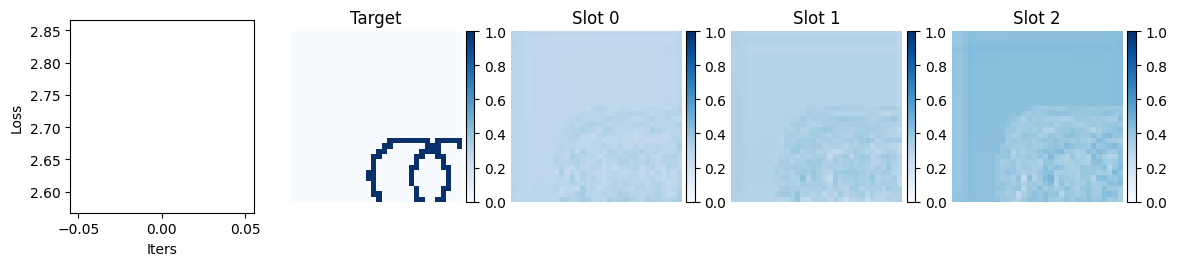

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 50 , loss 2.7068462 , lr 2.999988434072206e-06


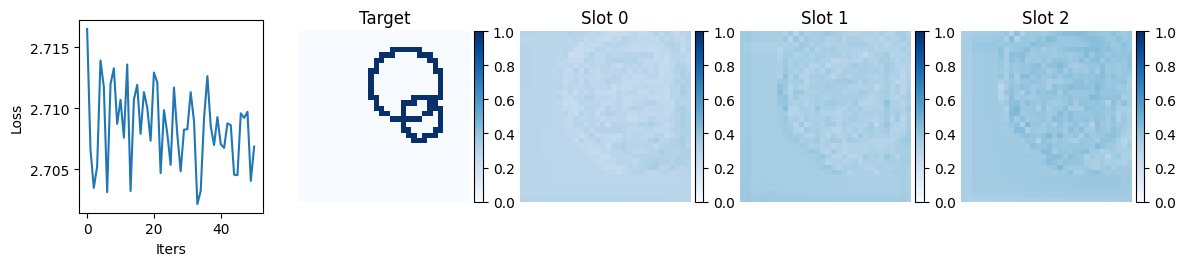

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 100 , loss 2.6917915 , lr 5.999907472934369e-06


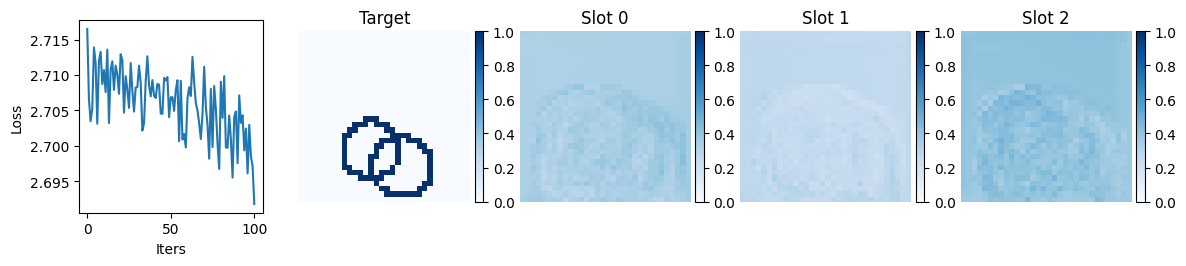

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 150 , loss 2.6770926 , lr 8.999687723160046e-06


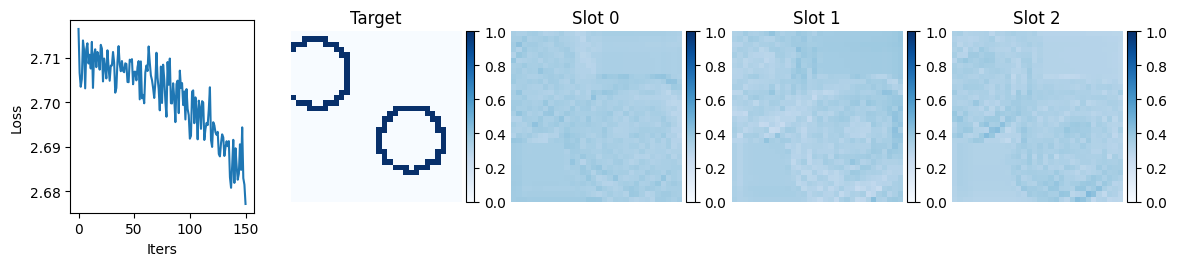

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 200 , loss 2.6583872 , lr 1.1999259794889963e-05


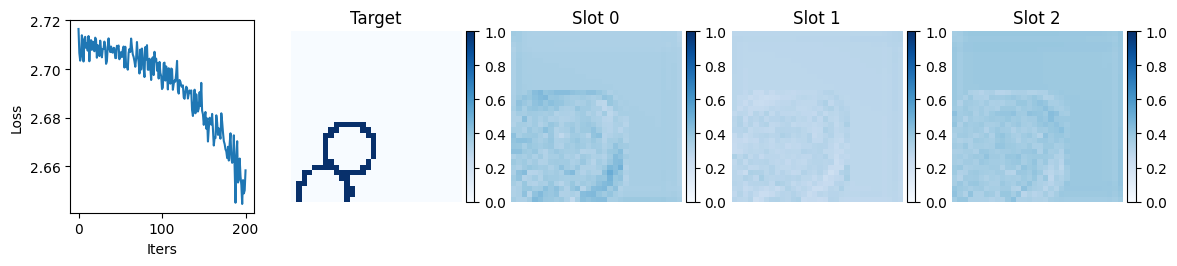

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 250 , loss 2.6087842 , lr 1.4998554303615487e-05


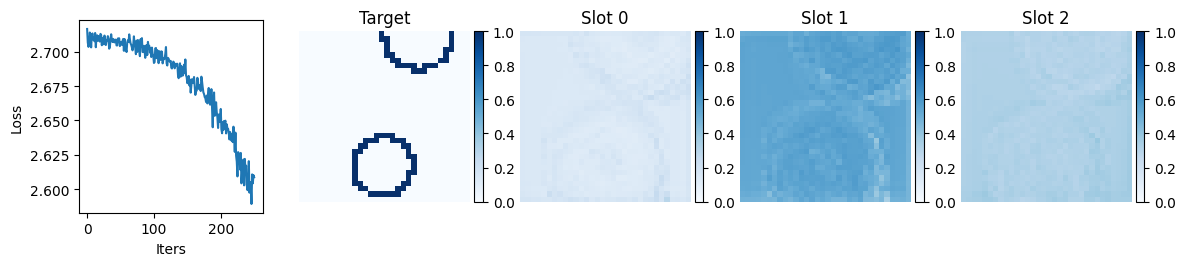

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 300 , loss 2.5145638 , lr 1.7997501871962002e-05


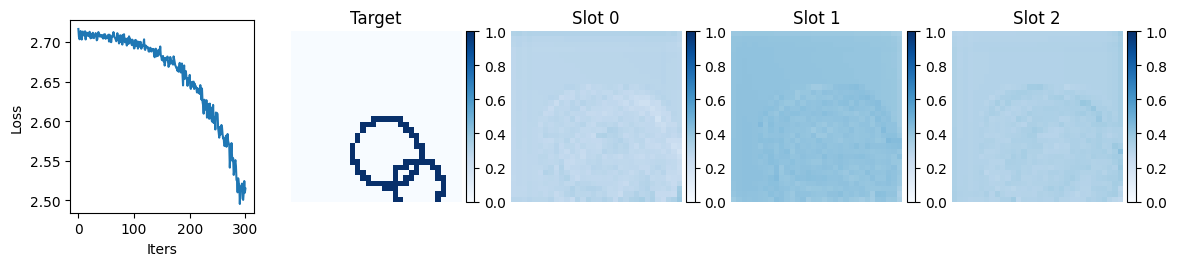

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 350 , loss 2.3903651 , lr 2.0996033131472145e-05


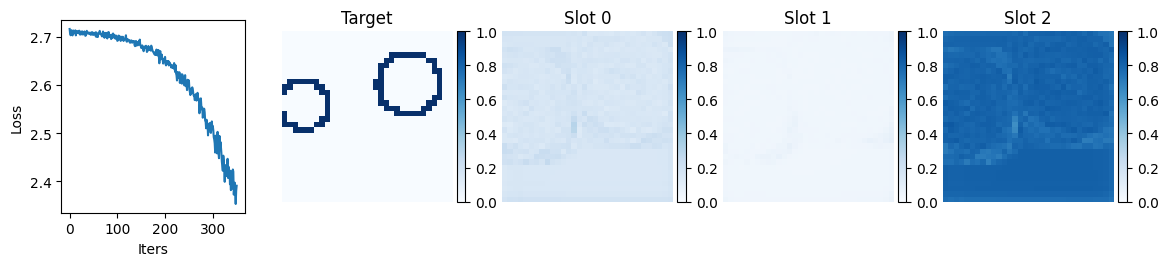

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 400 , loss 2.2713563 , lr 2.3994078724388778e-05


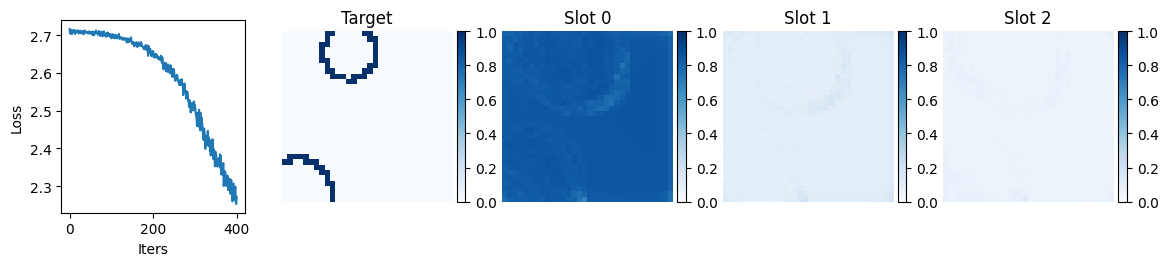

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 450 , loss 2.1941907 , lr 2.6991569305437837e-05


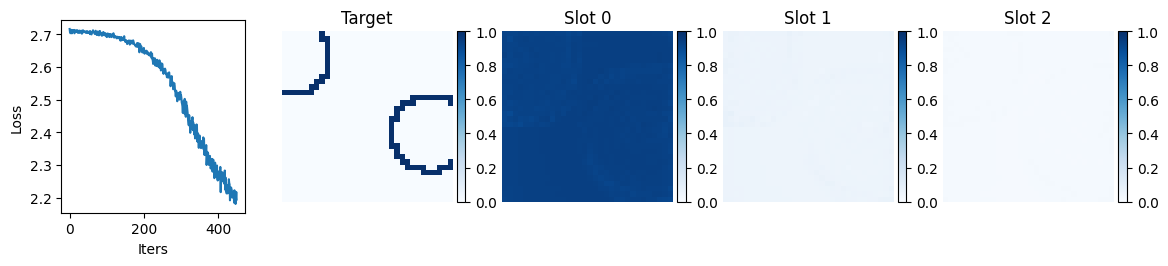

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 500 , loss 2.128707 , lr 2.9988435543610846e-05


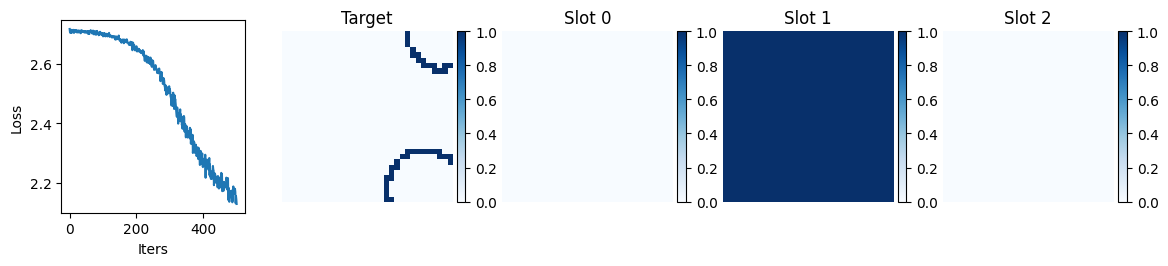

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 550 , loss 2.1294096 , lr 3.298460812394707e-05


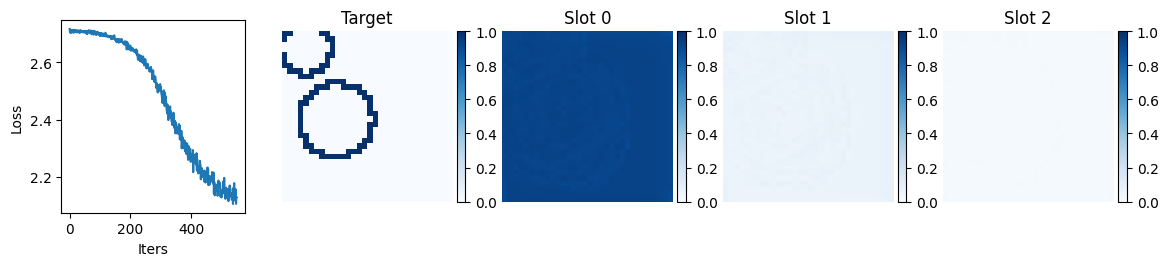

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 600 , loss 2.1130605 , lr 3.5980017749315456e-05


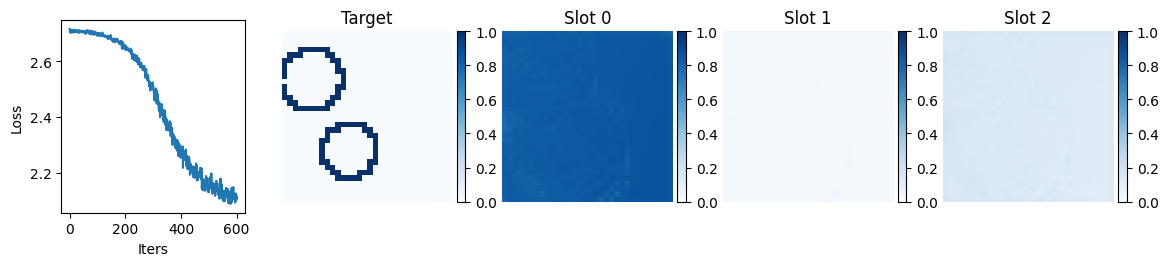

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 650 , loss 2.1012907 , lr 3.897459514219611e-05


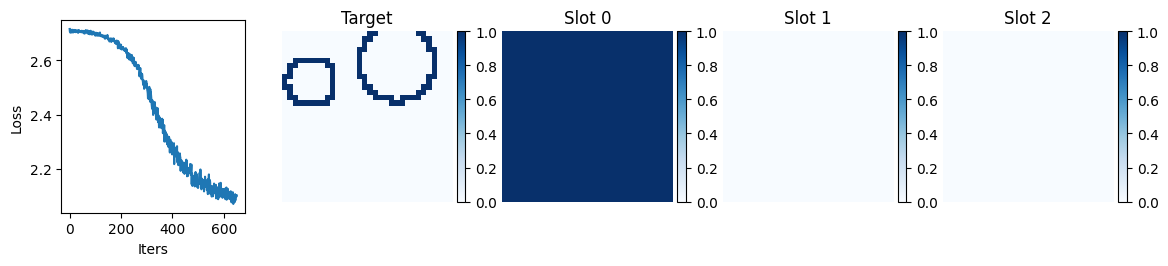

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 700 , loss 2.1016355 , lr 4.19682710464613e-05


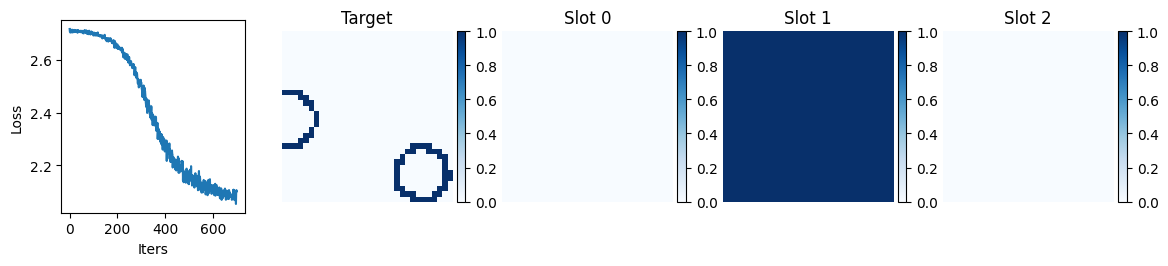

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 750 , loss 2.0567718 , lr 4.4960976229156103e-05


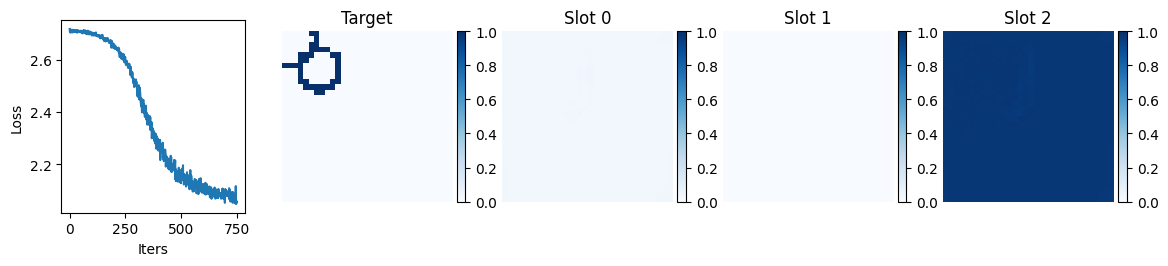

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 800 , loss 2.0582771 , lr 4.7952641482278515e-05


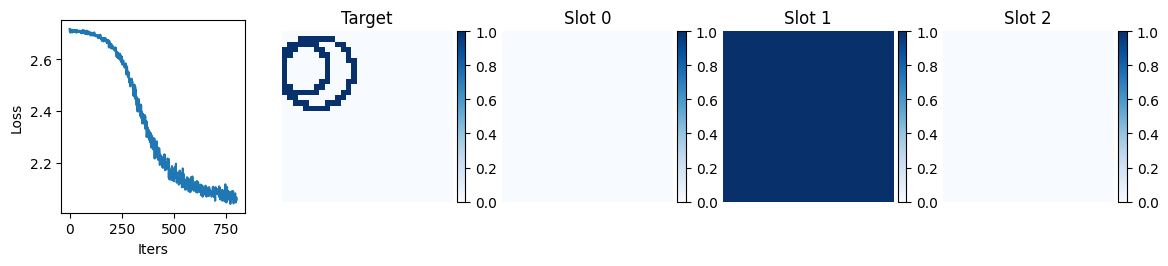

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 850 , loss 2.0593774 , lr 5.094319762455895e-05


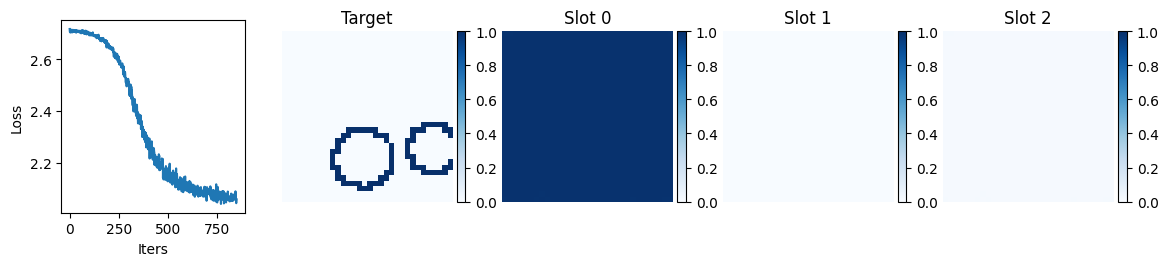

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 900 , loss 2.0518456 , lr 5.393257550323929e-05


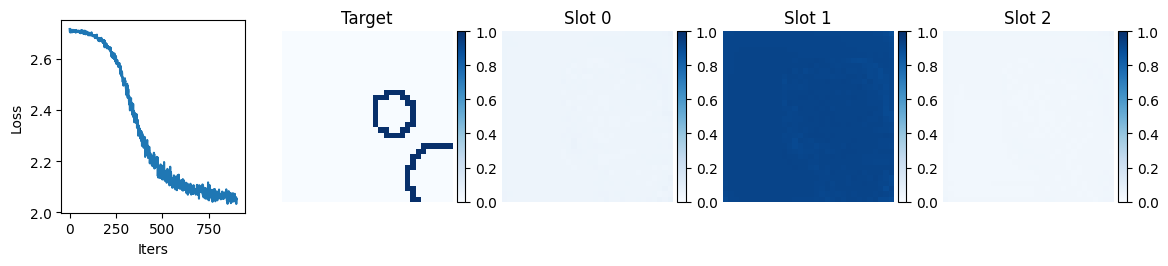

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 950 , loss 2.0473022 , lr 5.692070599585119e-05


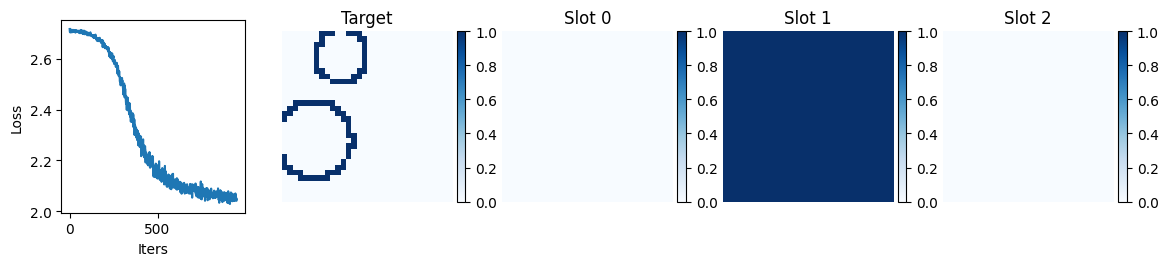

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1000 , loss 2.0615664 , lr 5.9907520011993834e-05


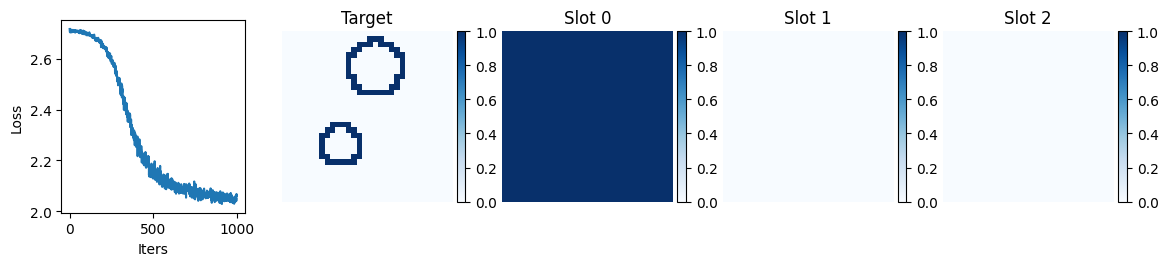

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1050 , loss 2.045208 , lr 6.289294849511095e-05


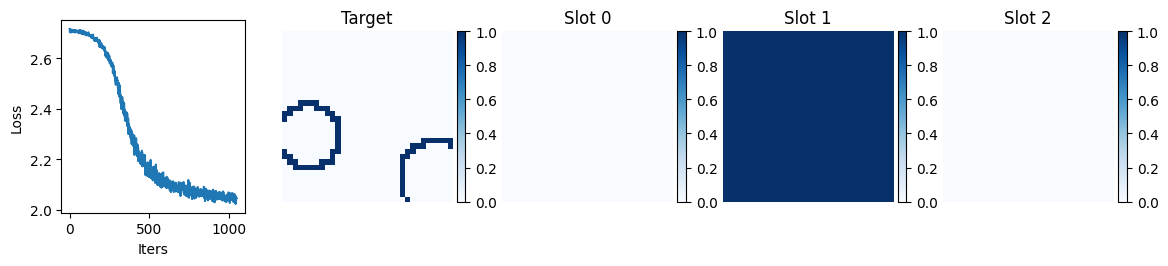

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1100 , loss 2.0511818 , lr 6.587692242426705e-05


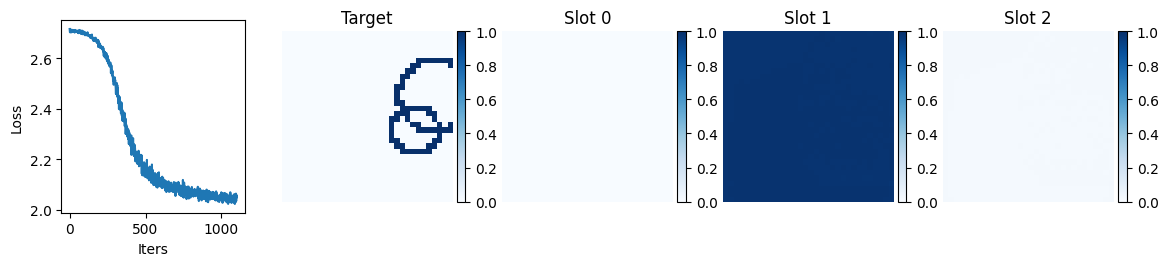

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1150 , loss 2.0361848 , lr 6.885937281592306e-05


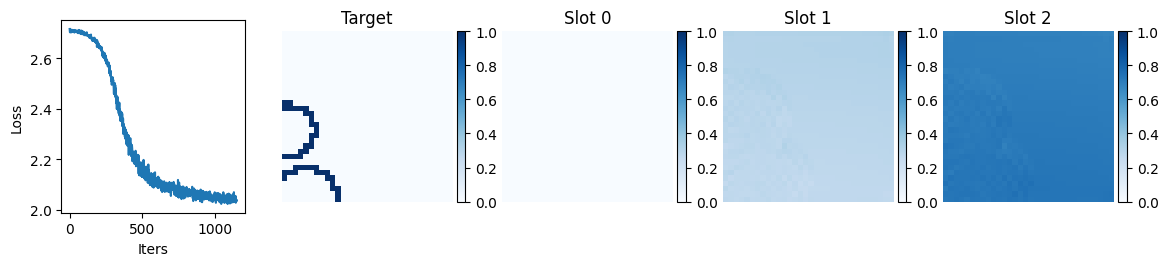

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1200 , loss 2.0358257 , lr 7.184023072571087e-05


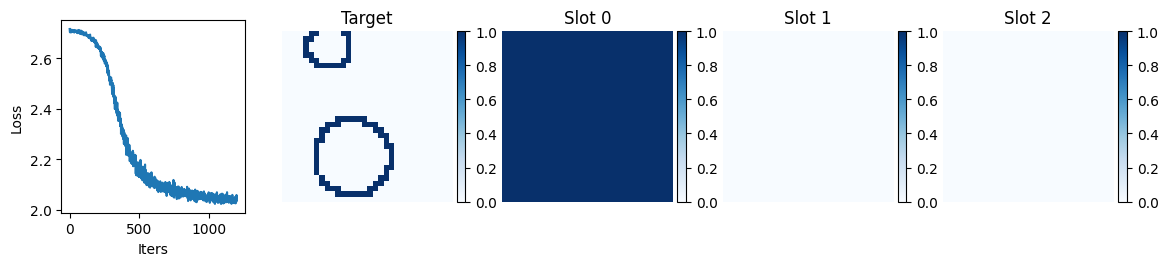

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1250 , loss 2.0476565 , lr 7.481942725020738e-05


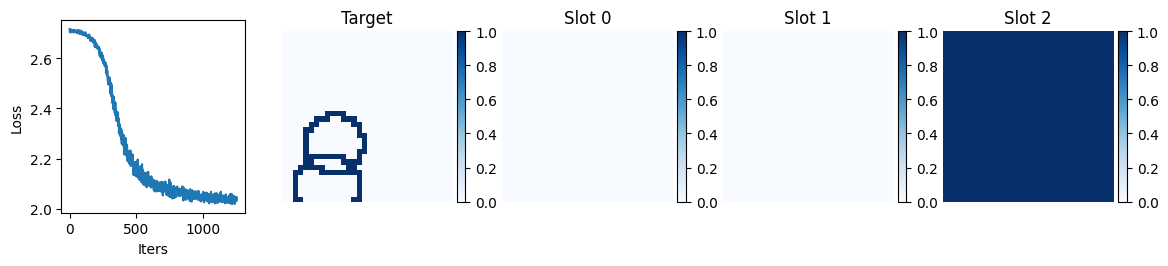

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1300 , loss 2.034934 , lr 7.779689352870732e-05


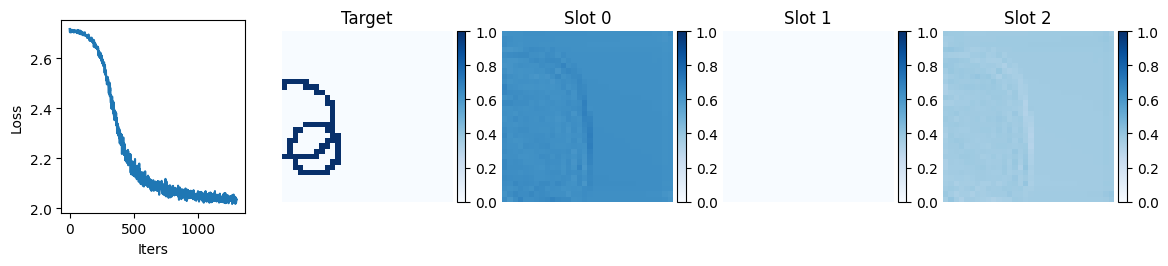

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1350 , loss 2.0301116 , lr 8.077256074499546e-05


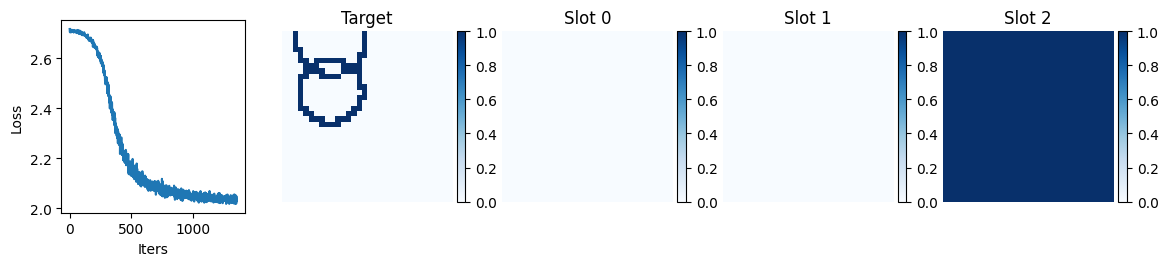

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1400 , loss 2.0146308 , lr 8.374636012911756e-05


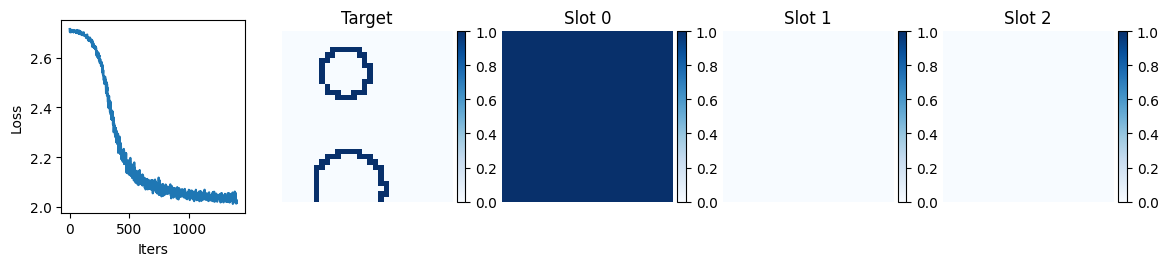

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1450 , loss 2.0230606 , lr 8.671822295915055e-05


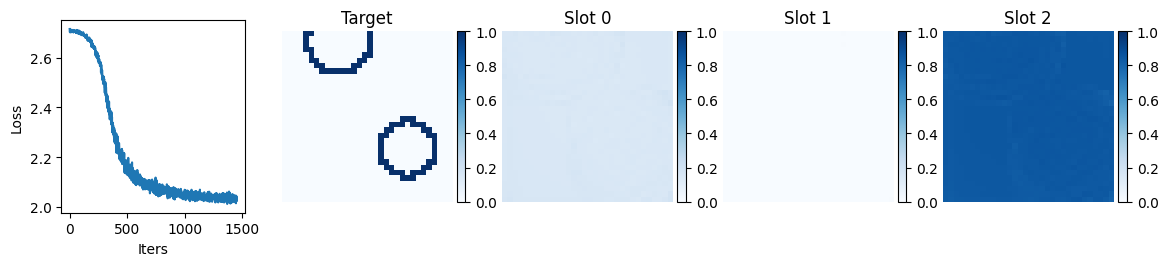

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1500 , loss 2.0370932 , lr 8.968808056297168e-05


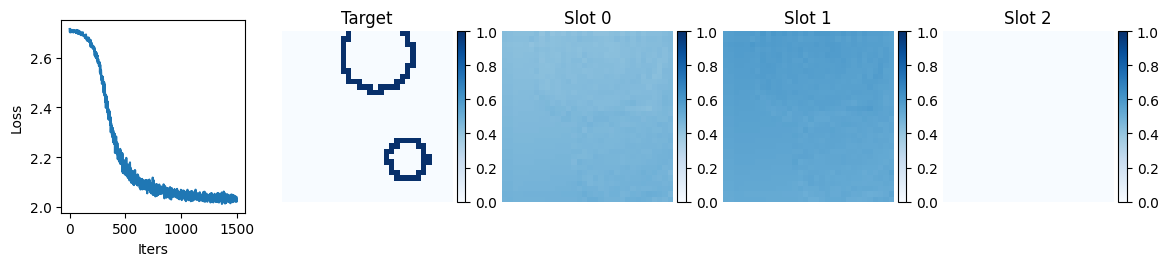

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1550 , loss 2.020776 , lr 9.26558643200263e-05


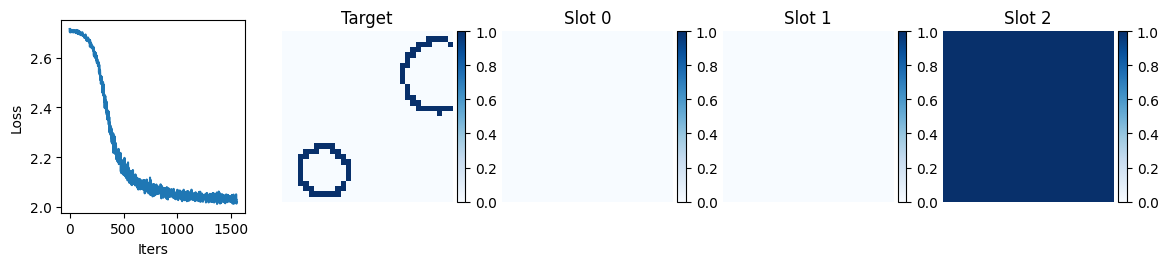

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1600 , loss 2.0333705 , lr 9.562150566309494e-05


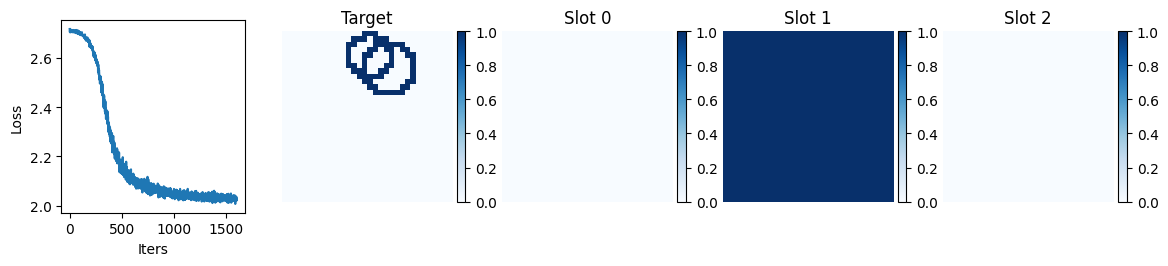

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1650 , loss 2.020929 , lr 9.858493608005883e-05


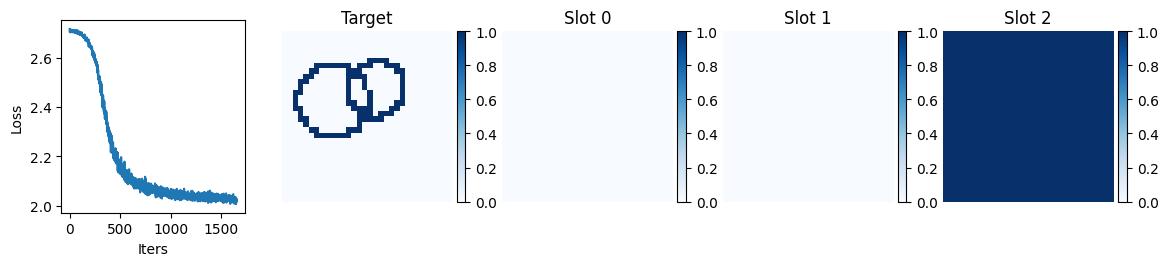

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1700 , loss 2.0316179 , lr 0.00010154608711566472


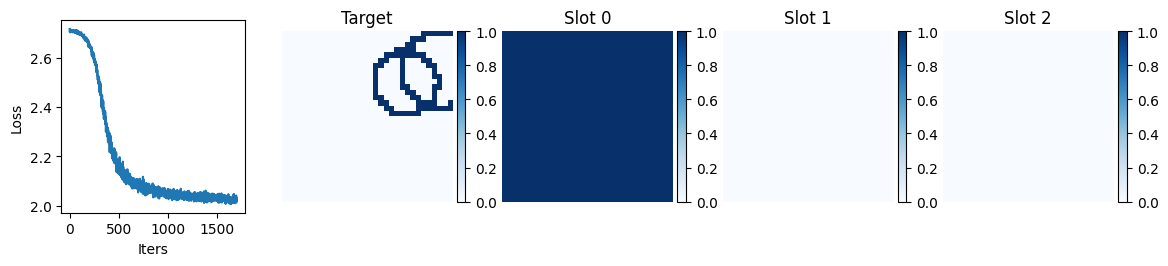

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1750 , loss 2.040753 , lr 0.0001045048903732878


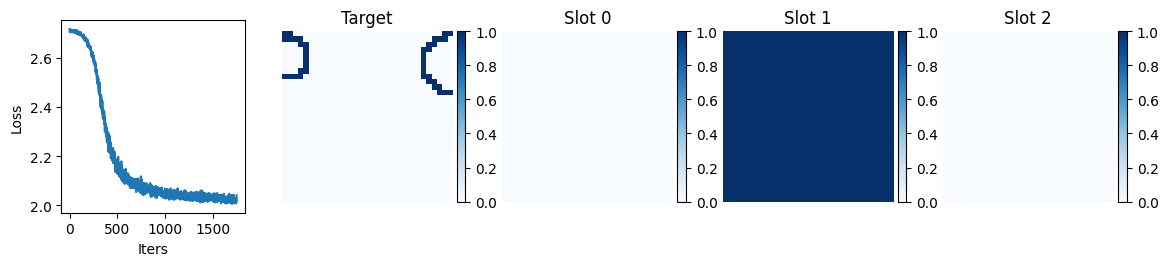

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1800 , loss 2.0165253 , lr 0.00010746127751669408


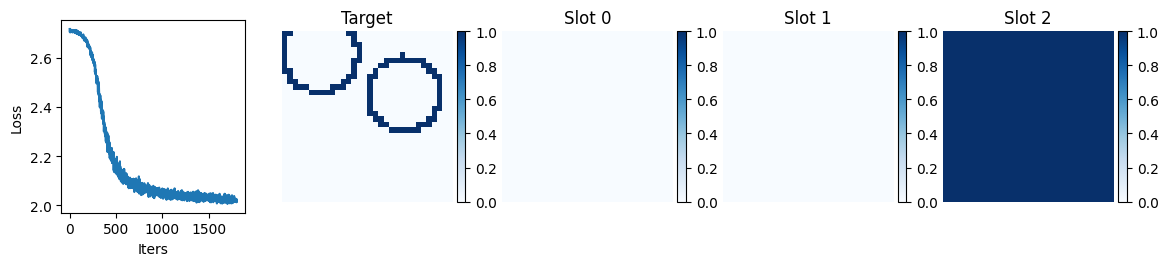

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1850 , loss 2.0185118 , lr 0.000110415180271801


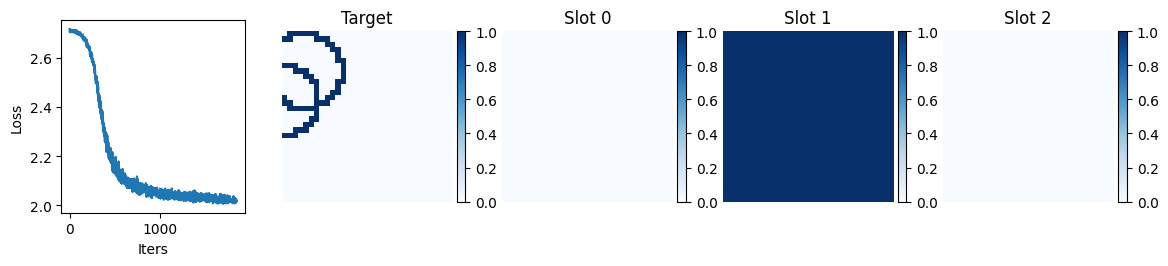

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1900 , loss 2.0048323 , lr 0.00011336653042843675


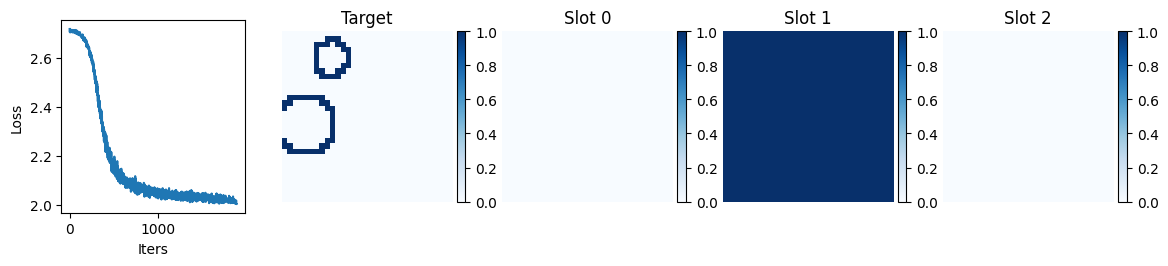

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 1950 , loss 2.0039039 , lr 0.00011631525984209833


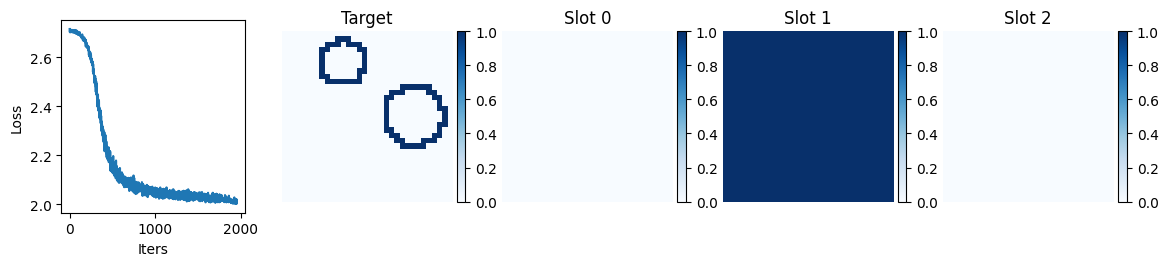

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2000 , loss 2.008826 , lr 0.00011926130043570826


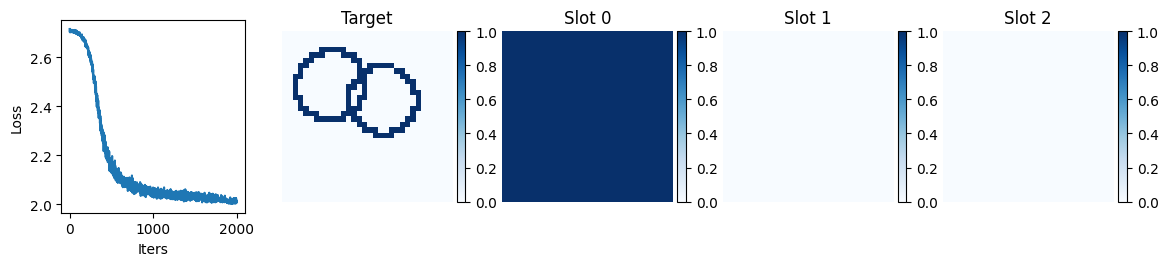

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2050 , loss 2.018223 , lr 0.00012220458420136946


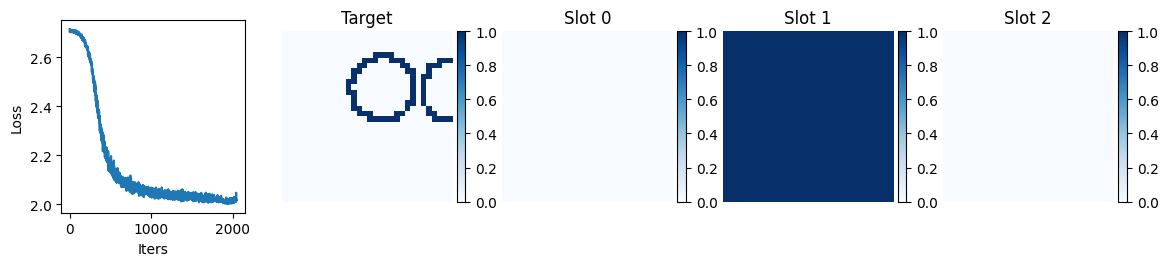

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2100 , loss 2.0213969 , lr 0.0001251450432021192


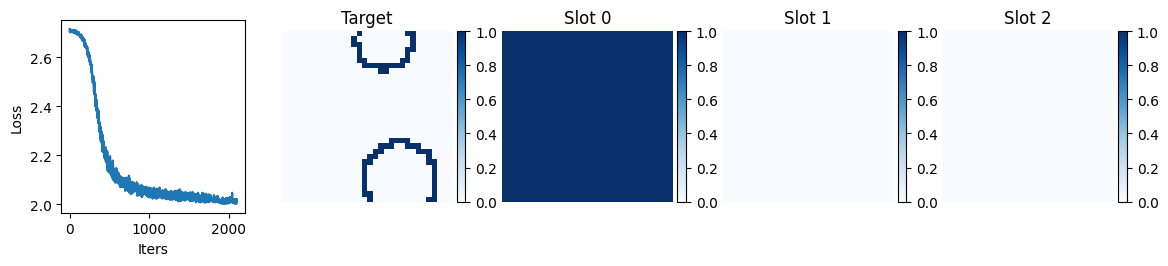

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2150 , loss 2.005047 , lr 0.00012808260957368096


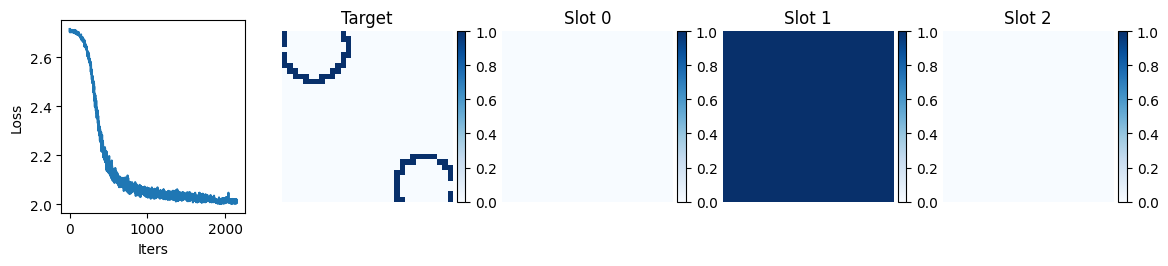

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2200 , loss 2.007448 , lr 0.00013101721552621508


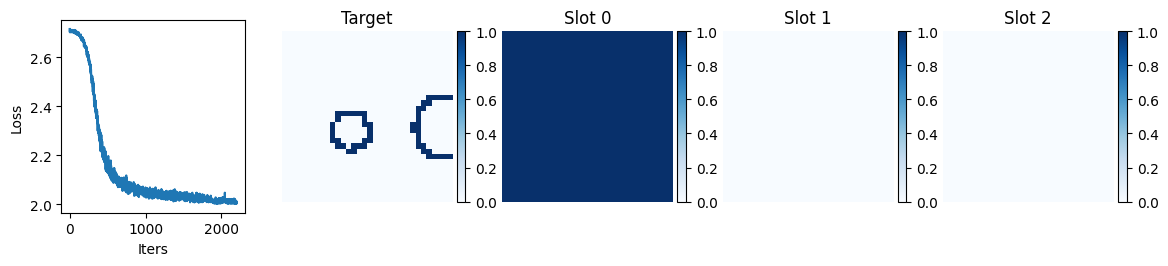

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2250 , loss 2.005408 , lr 0.00013394879334606766


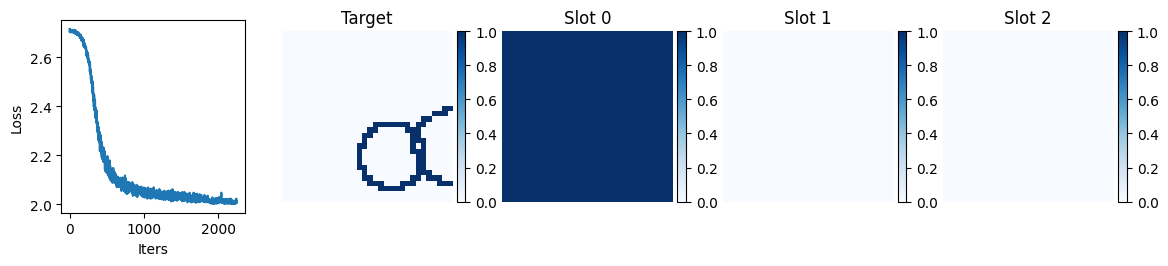

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2300 , loss 2.005329 , lr 0.00013687727539751795


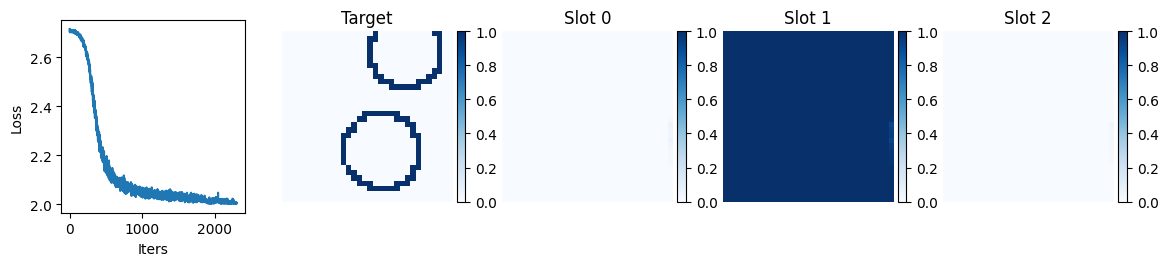

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2350 , loss 2.0133386 , lr 0.0001398025941245238


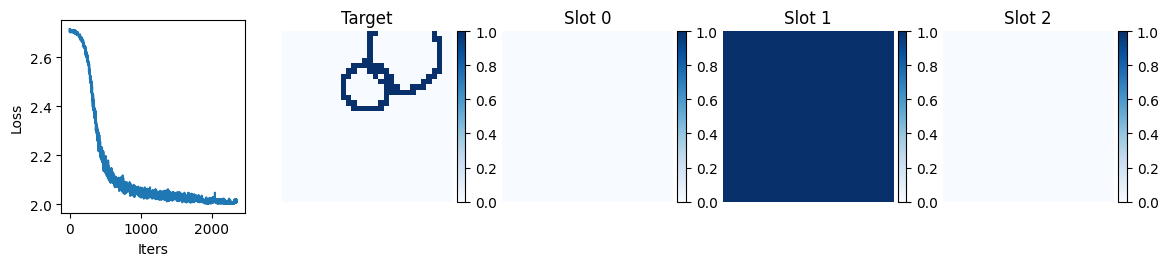

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2400 , loss 2.0066962 , lr 0.00014272468205246558


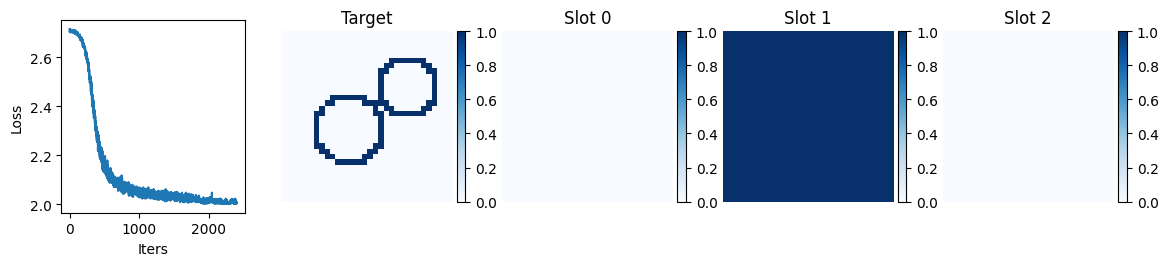

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2450 , loss 2.000452 , lr 0.0001456434717898884


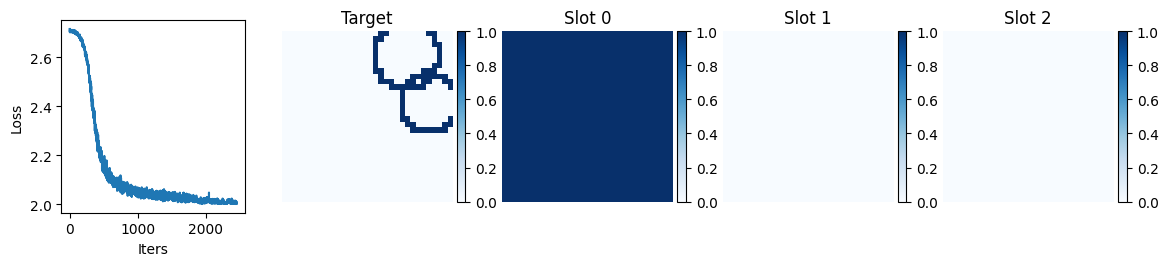

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2500 , loss 2.0194788 , lr 0.00014855889603024227


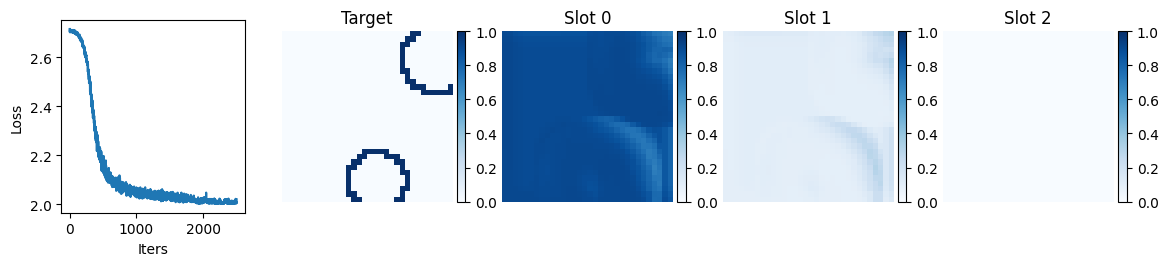

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2550 , loss 2.013472 , lr 0.00015147088755362083


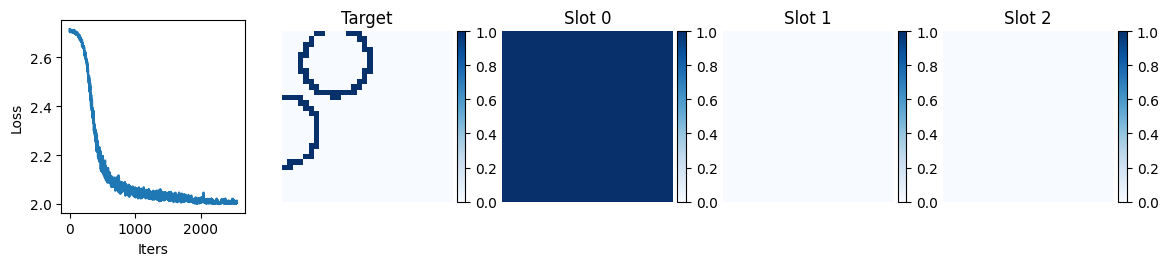

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2600 , loss 2.0024562 , lr 0.0001543793792284977


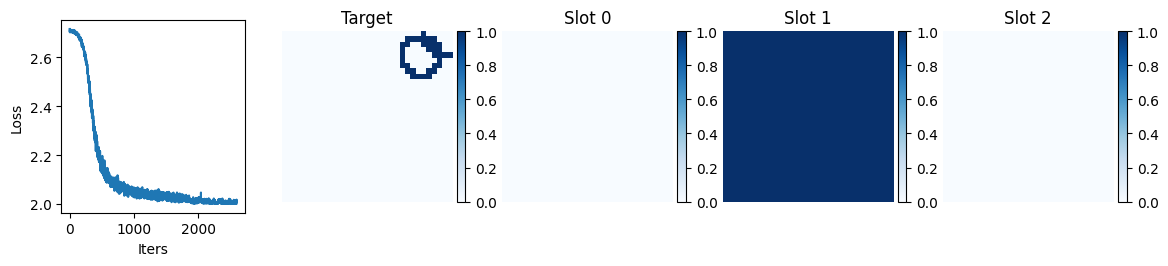

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2650 , loss 2.0141487 , lr 0.00015728430401346143


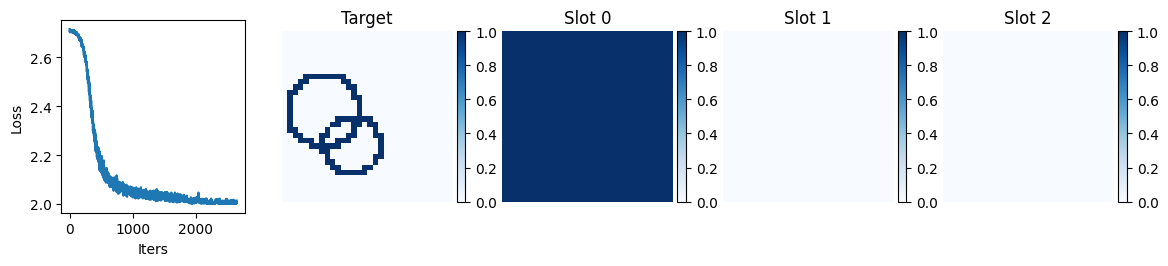

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2700 , loss 2.0029912 , lr 0.00016018559495894805


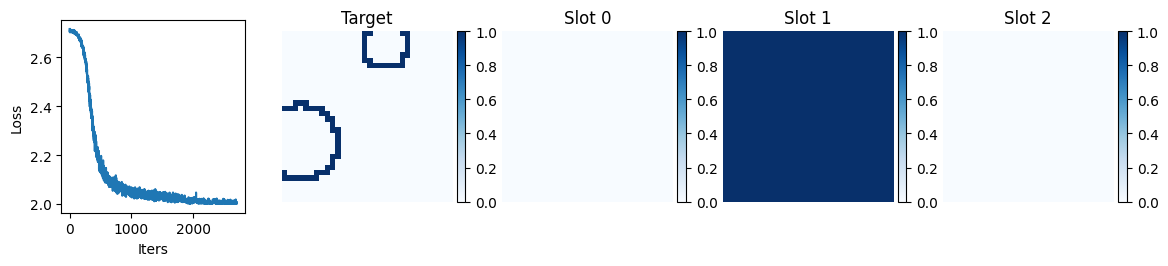

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2750 , loss 2.0020113 , lr 0.00016308318520897198


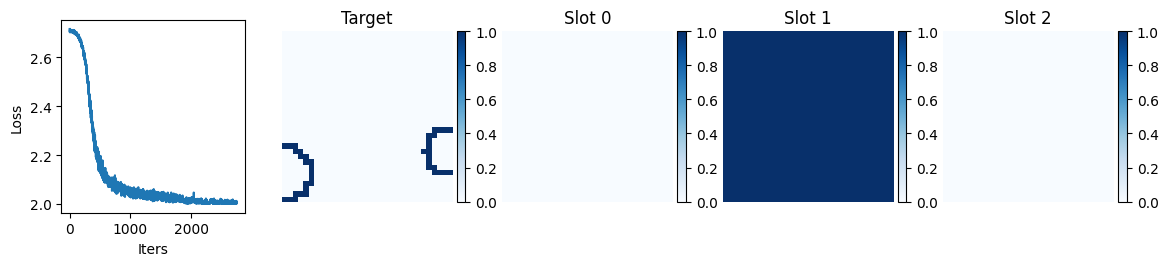

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2800 , loss 2.0074282 , lr 0.0001659770080028548


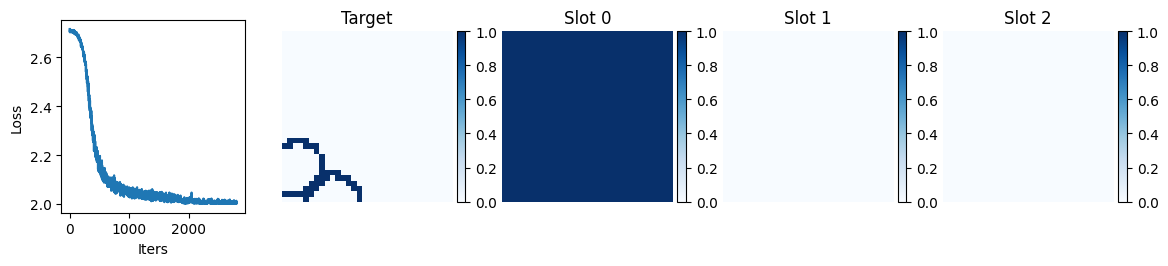

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2850 , loss 2.0002189 , lr 0.00016886699667695182


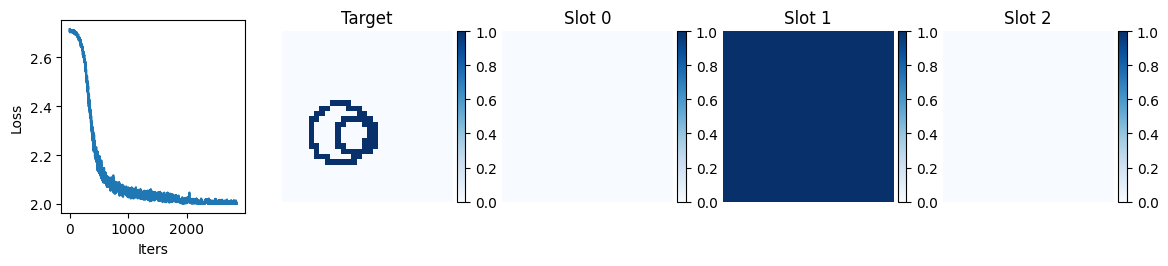

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2900 , loss 2.0091388 , lr 0.00017175308466637688


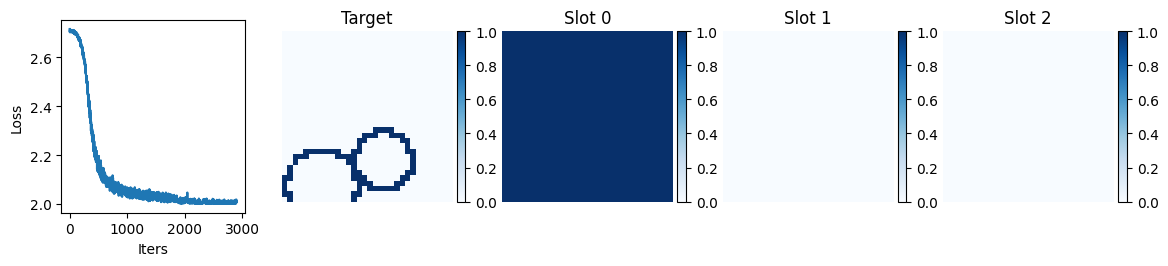

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 2950 , loss 2.003155 , lr 0.00017463520550672462


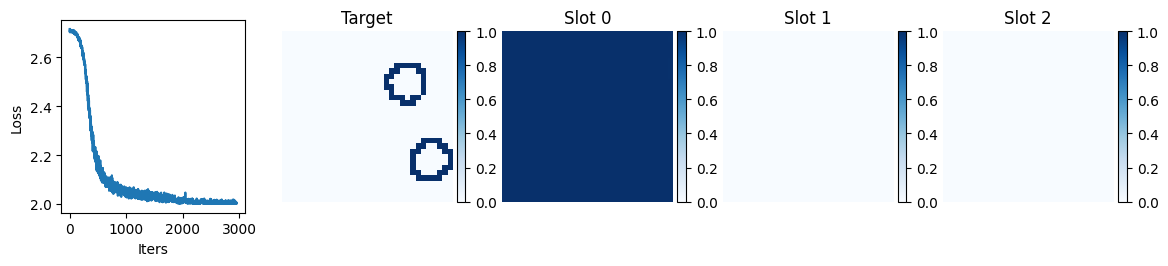

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3000 , loss 2.0097065 , lr 0.00017751329283579087


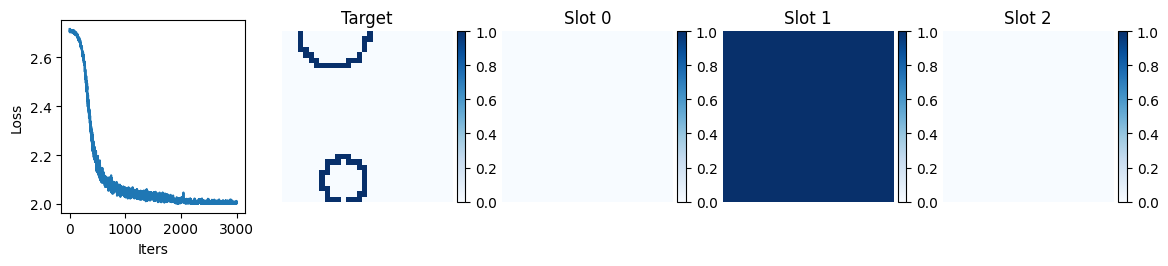

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3050 , loss 2.0044475 , lr 0.00018038728039529076


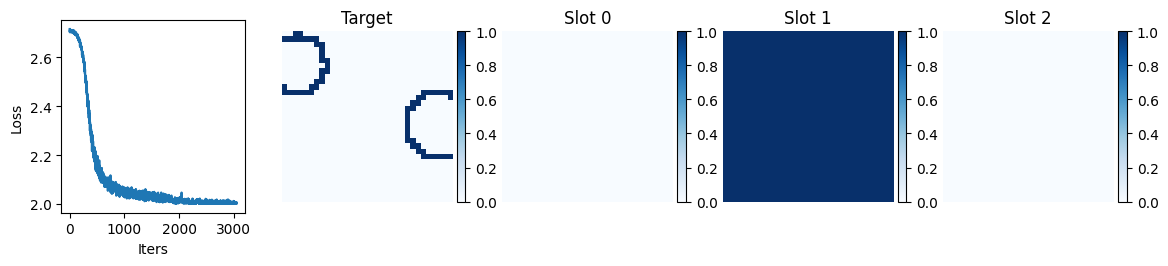

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3100 , loss 2.0051842 , lr 0.00018325710203257443


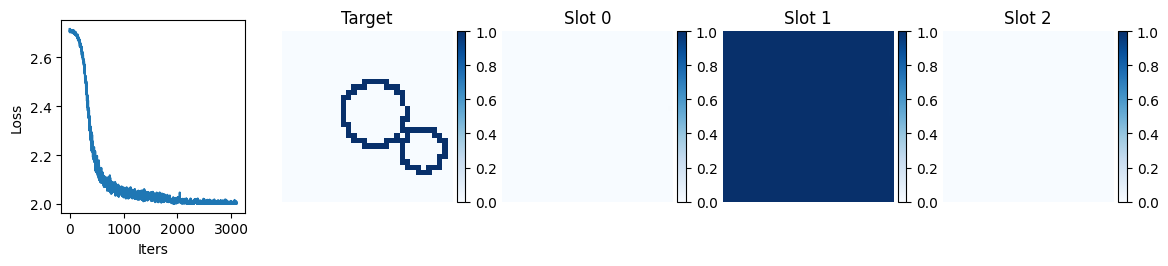

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3150 , loss 2.0031042 , lr 0.0001861226917023408


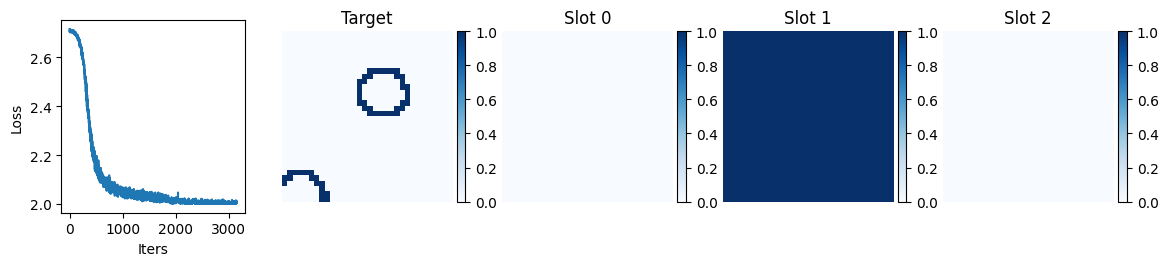

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3200 , loss 2.003319 , lr 0.00018898398346834858


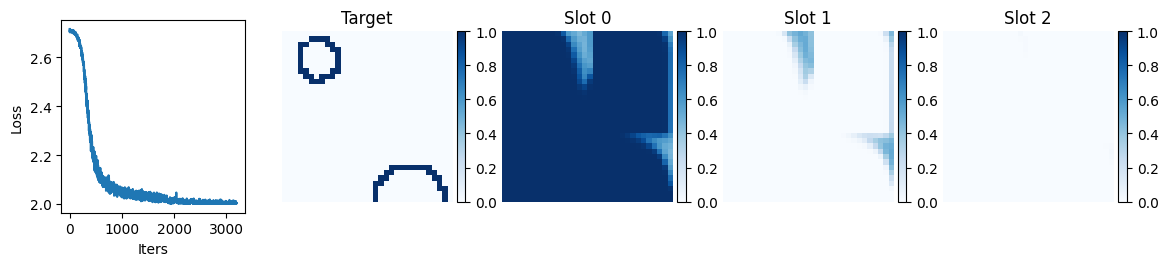

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3250 , loss 2.013096 , lr 0.00019184091150512532


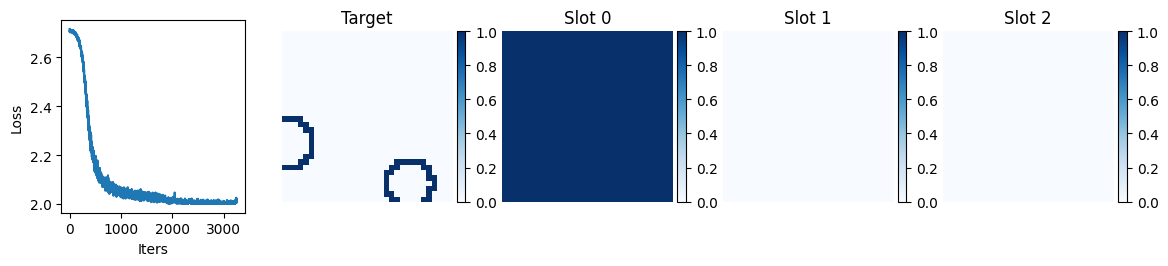

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3300 , loss 2.0035157 , lr 0.0001946934100996738


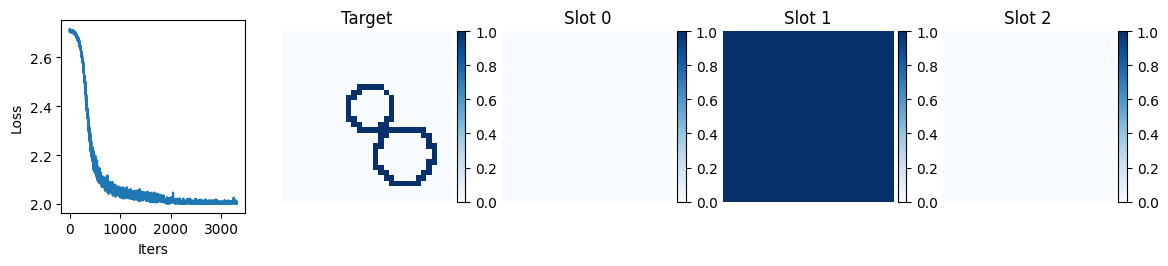

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3350 , loss 2.0018506 , lr 0.0001975414136531762


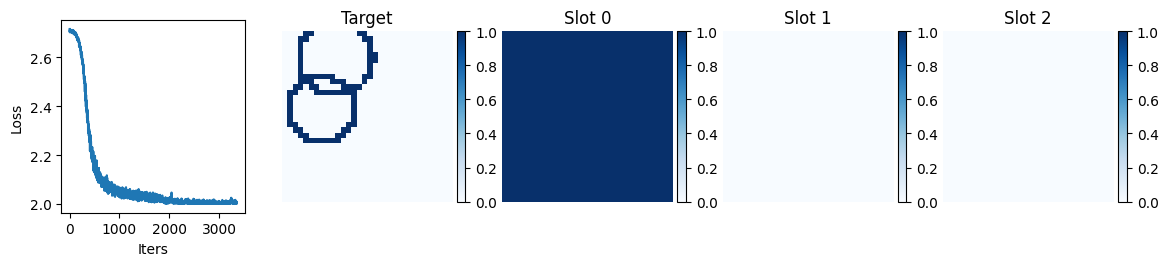

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3400 , loss 2.0013237 , lr 0.00020038485668269542


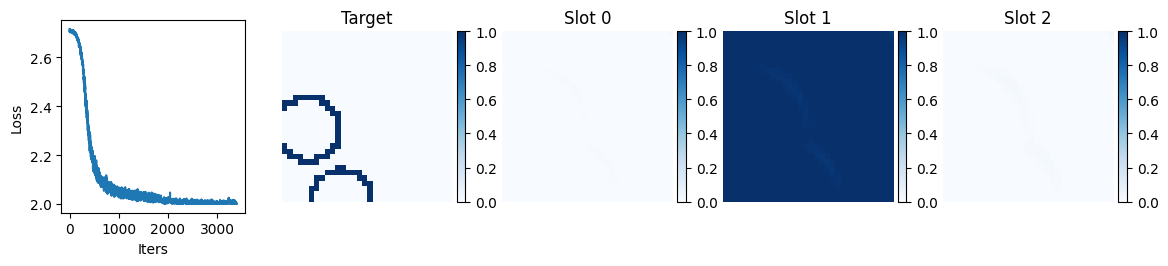

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3450 , loss 2.005074 , lr 0.00020322367382287444


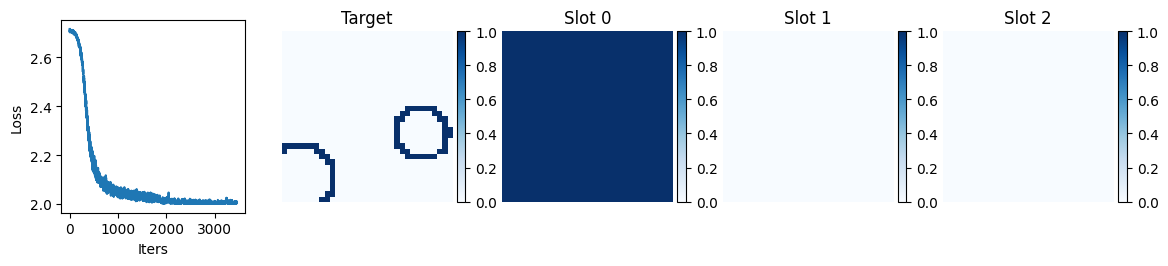

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3500 , loss 2.0055263 , lr 0.0002060577998276329


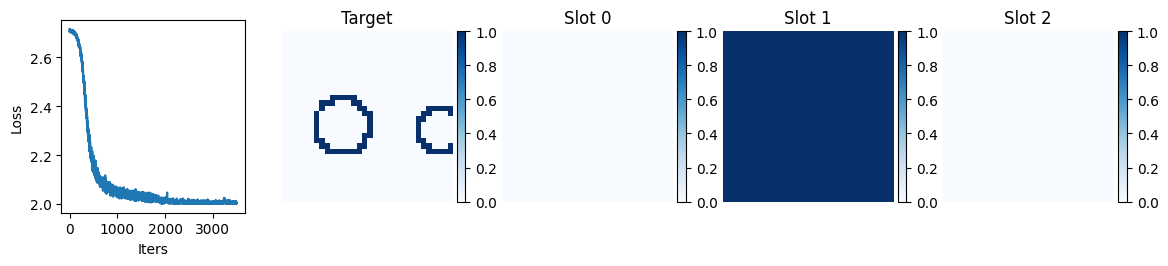

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3550 , loss 2.0065079 , lr 0.0002088871695718608


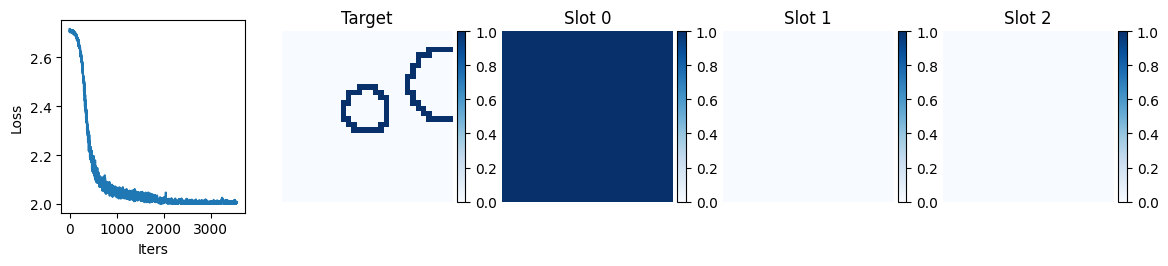

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3600 , loss 2.0041723 , lr 0.00021171171805310982


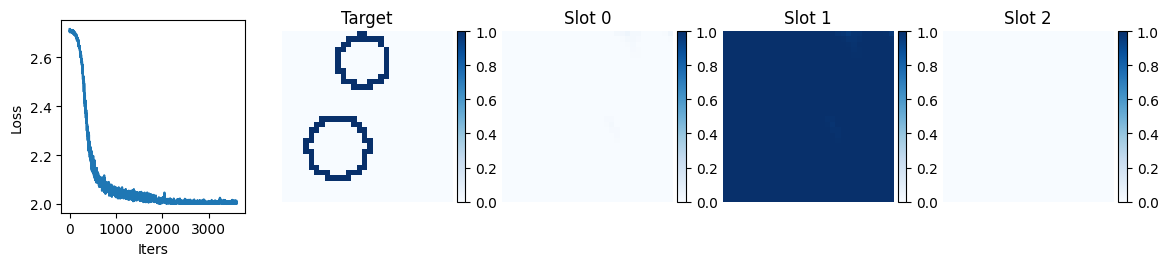

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3650 , loss 2.011594 , lr 0.00021453138039328242


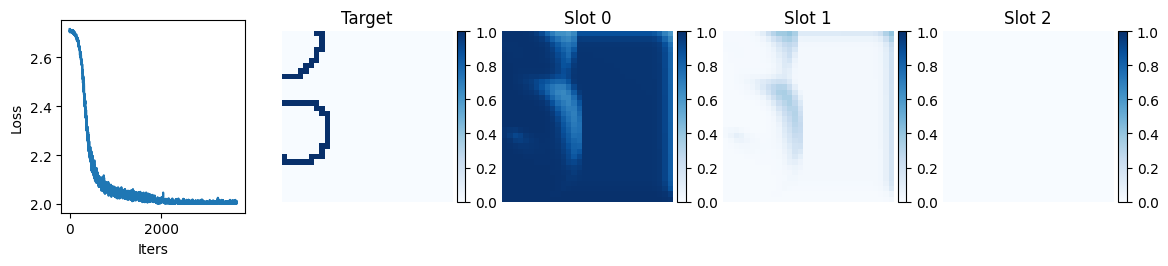

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3700 , loss 2.0023308 , lr 0.0002173460918403174


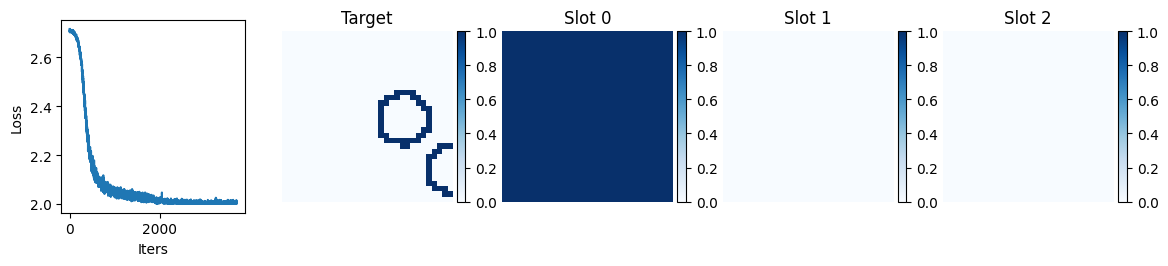

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3750 , loss 2.0162296 , lr 0.00022015578776987346


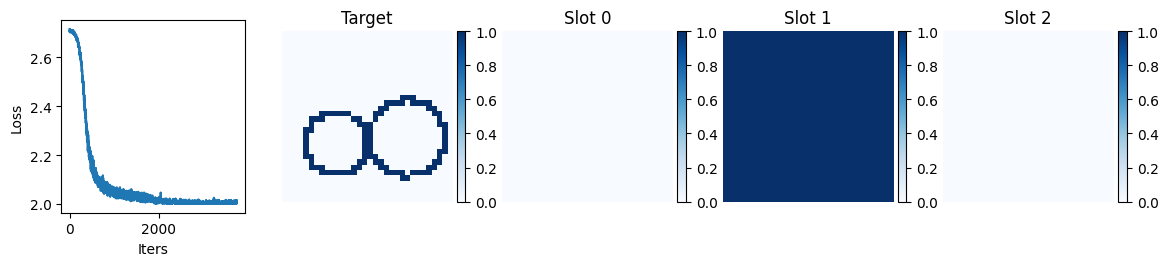

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3800 , loss 2.0114336 , lr 0.0002229604036870096


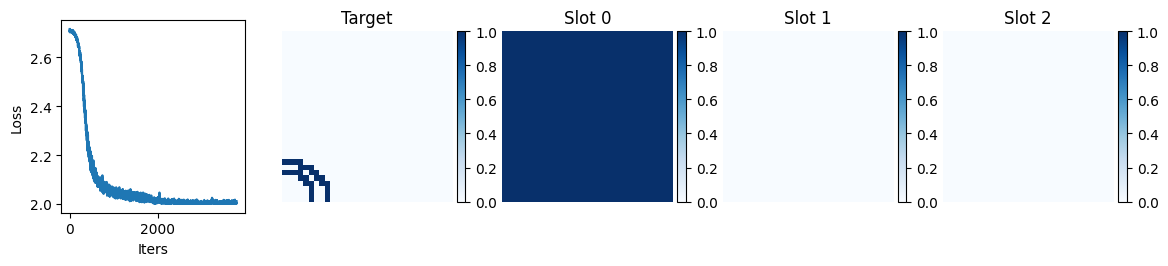

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3850 , loss 2.0071485 , lr 0.00022575987522786283


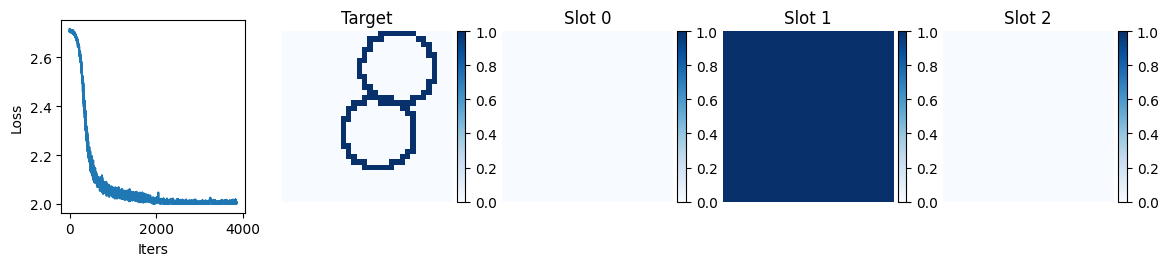

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3900 , loss 2.002725 , lr 0.0002285541381613231


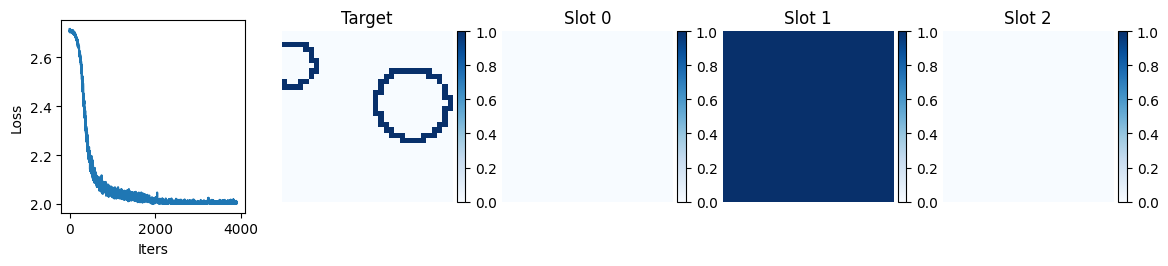

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 3950 , loss 2.0064354 , lr 0.00023134312839070533


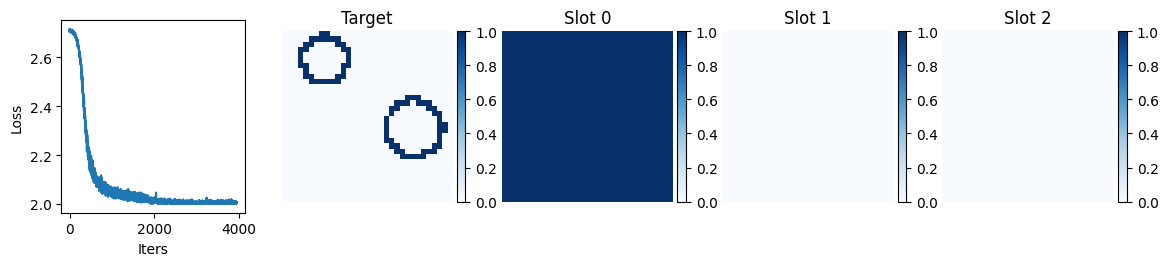

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 4000 , loss 2.0056756 , lr 0.00023412678195541844


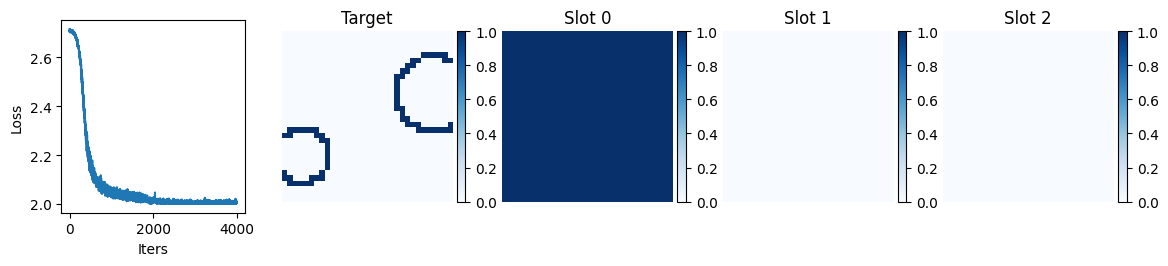

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 4050 , loss 2.01487 , lr 0.00023690503503263148


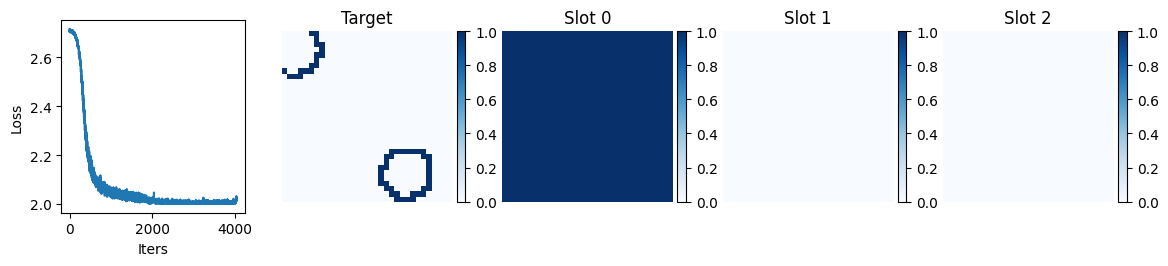

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 4100 , loss 2.011001 , lr 0.000239677823938937


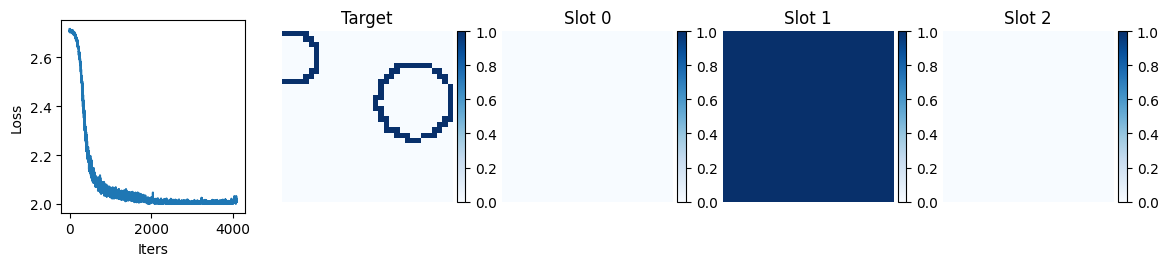

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 9800 , loss 2.0000238 , lr 0.0002577189446644783


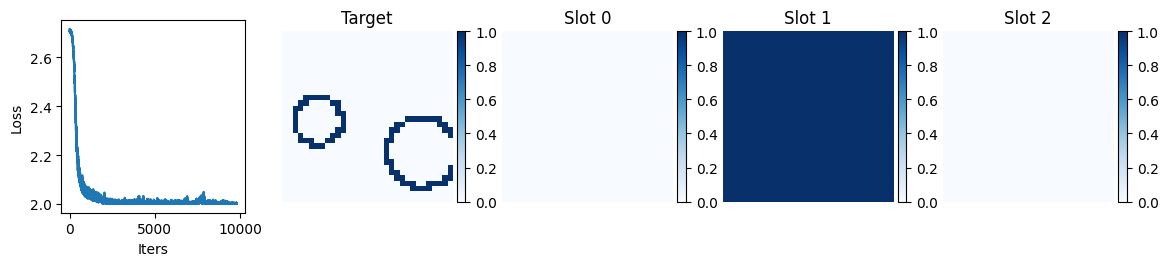

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 9850 , loss 2.0000002 , lr 0.0002573081886641374


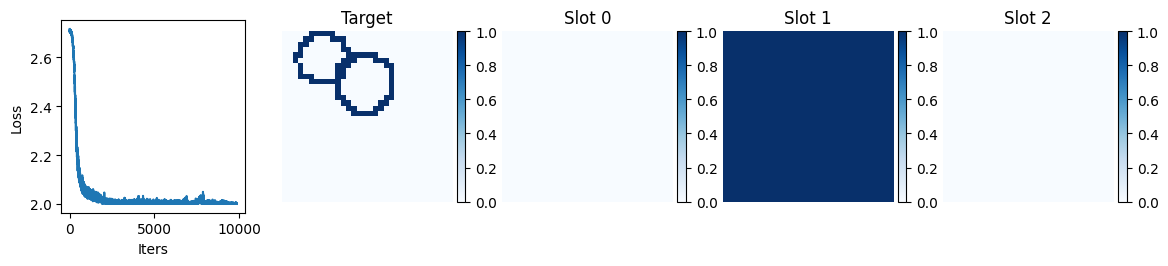

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 9900 , loss 2.002294 , lr 0.0002568957778387808


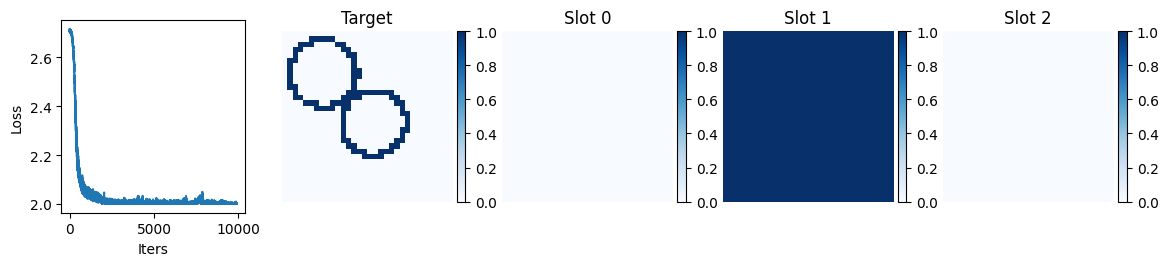

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 9950 , loss 2.0010586 , lr 0.00025648171854829354


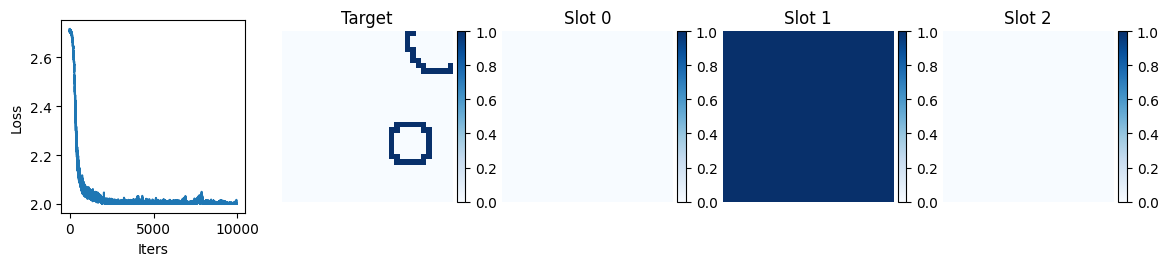

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 10000 , loss 2.0015078 , lr 0.00025606601717798207


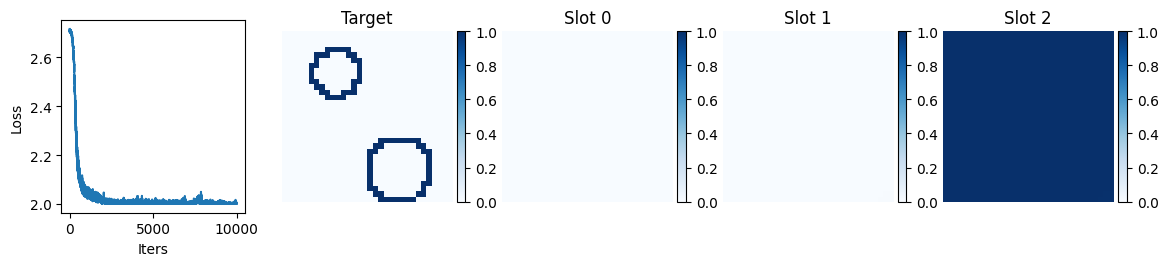

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 10050 , loss 2.0060246 , lr 0.00025564868013847595


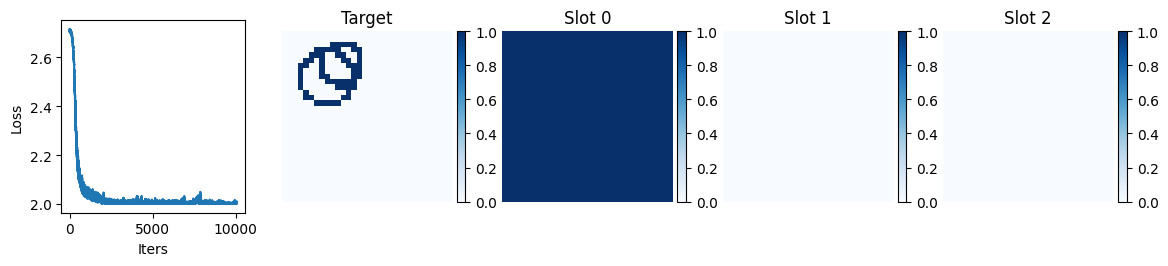

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 10100 , loss 2.0014715 , lr 0.00025522971386562833


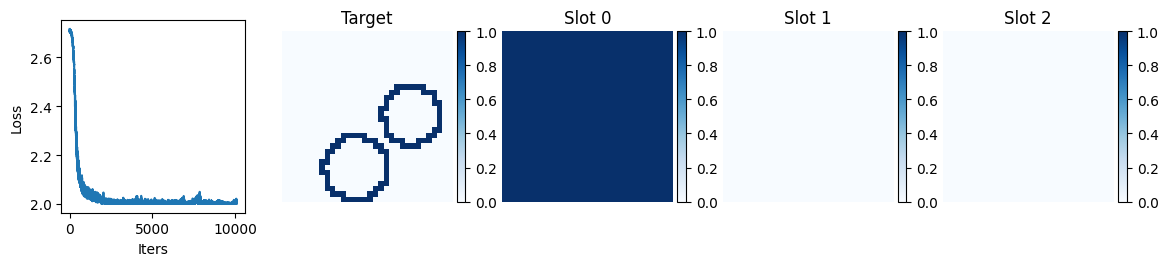

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 10150 , loss 2.0000684 , lr 0.0002548091248204176


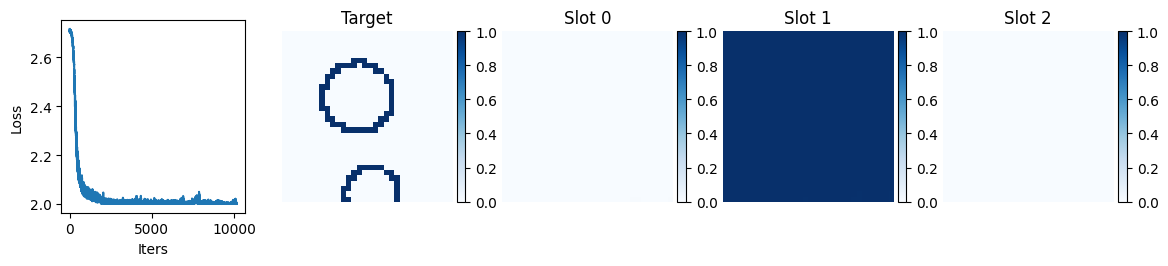

/raven/u/saumi/multi-object-detection/Slot-Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


In [ ]:
losses=[]

out = train_ISA(m,Ntrain=40_000,bs=bs,device=device,
                modelDir=modelDir,figDir=figDir,plot_every=50)

In [ ]:
model, X,Y,mask, init_q, init_pos = out

In [ ]:
queries, pos_scale, att, wts = model(X)

In [ ]:
att[4]

**Ideas:**
1. I could see if an L2 regularization would help
- Plot the min and max of the model parameters over time
2. Would gradient clipping help?
- I feel like it seems more sus smth else in the opt pipeline rn

In [ ]:
encoded_data

In [ ]:
i_fail = 0

In [ ]:
encoded_data = model.CNN_encoder(X) # Apply the CNN encoder
encoded_data = torch.permute(encoded_data,(0,2,3,1)) # Put channel dim at the end
encoded_data = torch.flatten(encoded_data,1,2) # flatten pixel dims
encoded_data = model.dataN(encoded_data)

# Use the init Q from the failure mode
queries = copy(init_q)
pos_scale = copy(init_pos)

'''
Step 3: Iterate through the reconstruction
'''
for i in range(model.n_iter):
    # queries, pos_scale = model.iterate(queries, pos_scale, encoded_data)    

    print('t=',i)
    
    # Get the keys and values in the ref ref frame
    keys, vals = model.get_keys_vals(encoded_data,pos_scale)

    print('keys',keys[i_fail].isnan().sum().item(),f'max {keys[i_fail].max().item():.2f},min {keys[i_fail].min().item():.2f}')
    print('vals',vals[i_fail].isnan().sum().item(),f'max {vals[i_fail].max().item():.2f},min {vals[i_fail].min().item():.2f}')
    
    # att,wts: (bs, k_slots, img_dim)
    att,wts = model.attention_and_weights(model.queryN(queries),keys)   

    print('att',att[i_fail].isnan().sum().item(),f'max {att[i_fail].max().item():.2f},min {att[i_fail].min().item():.2f}')
    print('wts',wts[i_fail].isnan().sum().item(),f'max {wts[i_fail].max().item():.2f},min {wts[i_fail].min().item():.2f}')

    new_pos_scale = model.update_frames(wts)

    # Update the queries with the recurrent block
    updates = torch.einsum('bsd,bsde->bse',wts,vals) # bs, n_slots, query_dim

    updates = model.gru(
        updates.reshape(-1,model.query_dim),
        queries.reshape(-1,model.query_dim),
    )

    queries,pos_scale = updates.reshape(queries.shape), new_pos_scale
    
    
    print(i,queries[i_fail],pos_scale[i_fail])
    
    break
    
    
# # With the final query vector, calc the attn, weights, + rel ref frames
# keys, vals = model.get_keys_vals(encoded_data,pos_scale)
# att, wts = model.attention_and_weights(model.queryN(queries),keys)   
# new_pos_scale = model.update_frames(wts)

In [ ]:
X2, Y2, mask2 = make_batch(N_events=2,device=device, **{'isRing': True, 'N_clusters':2})
        

In [ ]:
# m_cpu = model.to(device)

In [ ]:
model(X2)

In [ ]:
plt.hist(encoded_data.flatten().detach().cpu().numpy())

In [ ]:
# Get the relative position embedding
rel_grid = model.abs_grid.unsqueeze(1) - init_pos[:,:,:2].unsqueeze(2)
rel_grid /= init_pos[:,:,-1].unsqueeze(2).unsqueeze(-1)

# Embed it in the same space as the query dimension 
embed_grid = model.pixel_mult * model.dense( rel_grid )

# keys, vals: (bs, img_dim, query_dim)
k0 = model.toK(encoded_data).unsqueeze(1) + embed_grid
v0 = model.toV(encoded_data).unsqueeze(1) + embed_grid

k0 = model.init_mlp(k0)
v0 = model.init_mlp(v0)

In [ ]:
nb=100
r=(-5,5)
plt.hist(k0.flatten().detach().cpu().numpy(),nb,r,label='keys',
         color='g',histtype='step',lw=2)
plt.hist(v0.flatten().detach().cpu().numpy(),nb,r,label='values',
         color='b',histtype='step',lw=2)

plt.xlabel('features')
plt.ylabel('entries')
plt.legend()
plt.show()

In [ ]:
nb=100
r=(-5,5)
plt.hist(k0[i_fail].flatten().detach().cpu().numpy(),nb,r,label='keys',
         color='g',histtype='step',lw=2)
plt.hist(v0[i_fail].flatten().detach().cpu().numpy(),nb,r,label='values',
         color='b',histtype='step',lw=2)

plt.xlabel('features')
plt.ylabel('entries')
plt.title(f'Event {i_fail} (evt with nans)')
plt.legend()
plt.show()

In [ ]:
k0[i_fail].shape

In [ ]:
k0[i_fail][abs(k0[i_fail])>100]

In [ ]:
v0[i_fail][abs(v0[i_fail])>100]

In [ ]:
for p in model.parameters():
    print(p.shape,p)
    # plt.hist(p.detach().cpu().numpy(),histtype='step')

In [ ]:
losses

In [ ]:
att.isnan().sum()

In [ ]:
for i, att_i in enumerate(att):
    if att_i.isnan().sum() > 0:
        print(i)

In [ ]:
i_fail = 23

In [ ]:
init_q[i_fail]

In [ ]:
init_pos[i_fail]

In [ ]:
np.prod(att.shape)

In [ ]:
init_q

In [ ]:
init_pos

In [ ]:
copy(att)

In [ ]:
att.shape

In [ ]:
m,losses = out

In [ ]:
model, X,Y,mask = out

In [ ]:
queries, pos_scale, att, wts = m(X)
        
print( torch.isnan(att).sum() >0 )

In [ ]:
losses

In [ ]:
# att_img = att[iEvt].reshape(model.k_slots,*resolution)
# plot_kslots(losses, 
#             mask[iEvt].sum(axis=0).detach().cpu().numpy(), 
#             att_img.detach().cpu().numpy(),
#             k_slots, color=color,cmap=cmap,
#             figname=f'{figDir}/loss-slots-iter{i}-evt{iEvt}.jpg',showImg=showImg)
